# Plant function vs microbial community composition

Test principle components from growth residuals on microbial community composition using constrained analysis of principle components

In [25]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [26]:
%%R
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(DESeq2)
library(phyloseq)
library(doParallel)



In [27]:
%%R

log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')

physeq.Full = readRDS(F)

# read rhizosphere log2fold change file and 
l2f = read.csv(log2foldFile, header = TRUE) 
l2f = l2f[l2f$p.adj < .05,]
resp = l2f$OTU %>% unique %>% as.character
l2f = NULL

phy = filter_taxa(physeq.Full, function(x) sum(x > 0) > 0, TRUE)
phy = prune_taxa(resp, phy)
phy = subset_samples(phy, Plant != "BARE")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]


# Try ordination on pruned rhizosphere responder dataset

In [28]:
%%R
# Try PCoA 

ordu = ordinate(phy, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(phy, ordu, color="Plant", shape="Type") 

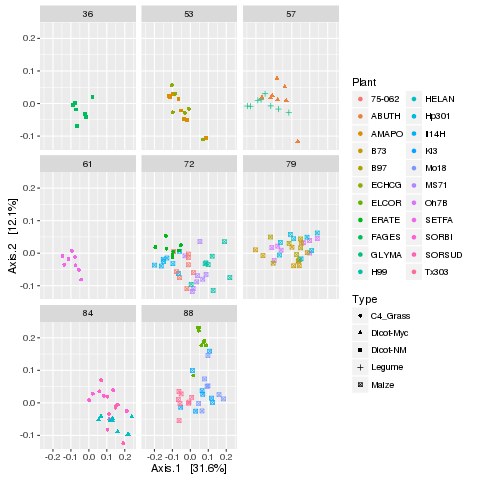

In [29]:
%%R
p + facet_wrap(~DAP)

# Overall Dataset

## CAP analysis

In [92]:
%%R
phy = subset_samples(physeq.Full, Plant != "BARE" & Treatment == "Nneg")
phy = subset_samples(phy, Type != "Maize" | Plant == "B73")



registerDoParallel(cores=28)
wunif.dist = distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
 [1] "B73"    "ECHCG"  "SETFA"  "SORBI"  "SORSUD" "ELCOR"  "ERATE"  "ABUTH" 
 [9] "HELAN"  "FAGES"  "AMAPO"  "GLYMA" 
Importance of components:
                          PC1    PC2    PC3    PC4
Standard deviation     1.2552 1.0563 0.9166 0.6845
Proportion of Variance 0.3939 0.2790 0.2100 0.1171
Cumulative Proportion  0.3939 0.6728 0.8829 1.0000
                        PC1         PC2         PC3        PC4
log(SeedSize_mg)  0.1778492 -0.87340188  0.08492315  0.4453390
A_Resid_logN     -0.5966333 -0.42374079  0.23880817 -0.6383127
A_Resid_logCN     0.6162050 -0.22455978 -0.45961345 -0.5988487
DAP               0.4823792  0.08476911  0.85118400 -0.1887068


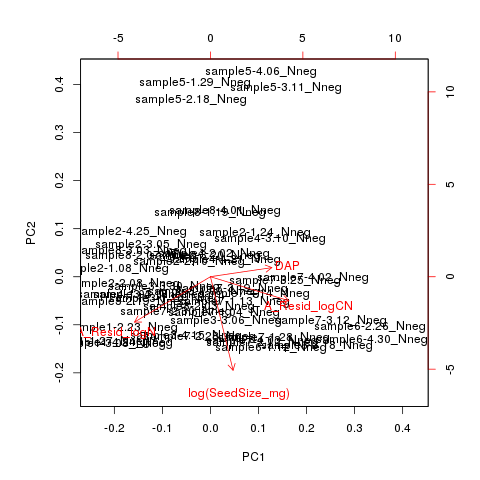

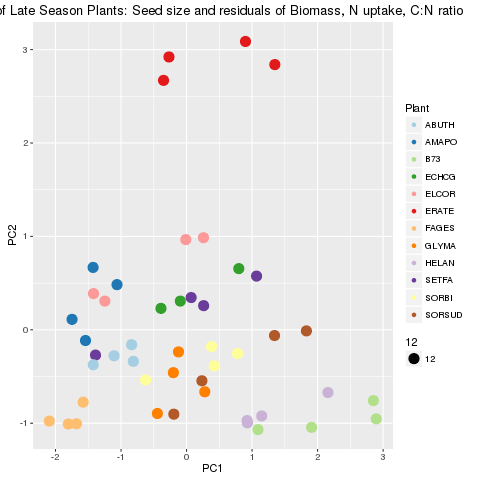

In [118]:
%%R
#add seed size
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric



# # PCA of annuals
sd = as(sample_data(phy), "data.frame")
sd$Plant %>% levels %>% print
sd = left_join(sd, SS, by = "Plant")

rownames(sd) = sd$X.sample
rownames(sd)
#sample_data(phy) = sd 

fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + DAP, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(phy) = TM_Fit



p = ggplot(TM_Fit, aes(PC1, PC2, colour = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Late Season Plants: Seed size and residuals of Biomass, N uptake, C:N ratio")
p

In [119]:
%%R
sample_data(phy.fit) %>% colnames

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[37] "NAG_activity_g"      "BX_rel"              "CB_rel"             
[40] "LAP_rel"             "NAG_rel"             "NO3_ug_g"           
[43] "

In [120]:
%%R
rcorr(as.matrix(sd[,c("tN_p", "Biomass_P", "DAP", "Plant_CN", "SeedSize_mg")]))
#rcorr(as.matrix(sd[,c("BX_activity_g", "CB_activity_g", "LAP_activity_g", "NAG_activity_g", "InorganicN")]))

             tN_p Biomass_P  DAP Plant_CN SeedSize_mg
tN_p         1.00      0.90 0.73     0.41       -0.11
Biomass_P    0.90      1.00 0.78     0.71        0.09
DAP          0.73      0.78 1.00     0.76        0.16
Plant_CN     0.41      0.71 0.76     1.00        0.44
SeedSize_mg -0.11      0.09 0.16     0.44        1.00

n= 47 


P
            tN_p   Biomass_P DAP    Plant_CN SeedSize_mg
tN_p               0.0000    0.0000 0.0038   0.4756     
Biomass_P   0.0000           0.0000 0.0000   0.5626     
DAP         0.0000 0.0000           0.0000   0.2981     
Plant_CN    0.0038 0.0000    0.0000          0.0019     
SeedSize_mg 0.4756 0.5626    0.2981 0.0019              


In [185]:
%%R -w 1000 -h 600

# sample_data(phy)$Plant = factor(sample_data(phy)$Plant, levels = c("75-062", "B73", "B97" ,  "H99" , "Hp301",
#                                                                       "Il14H",  "Ki3" , "Mo18", "MS71","Oh7B", "Tx303",
#                                                                       "ECHCG", "SETFA", "SORBI", "SORSUD", 
#                                                                       "ELCOR", "ERATE",
#                                                                       "ABUTH", "HELAN", "FAGES", "AMAPO", "GLYMA"))
                                                                       
sample_data(phy.fit)$Plant = factor(sample_data(phy.fit)$Plant, levels = c("B73", "ECHCG", "SETFA", "SORBI", "SORSUD", 
                                                                      "ELCOR", "ERATE",
                                                                      "ABUTH", "HELAN", "FAGES", "AMAPO", "GLYMA"))


sample_data(phy.fit)$DAP = sample_data(phy.fit)$DAP %>% as.character() %>% as.numeric()
unique(sample_data(phy.fit)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy.fit, 
    method = "CAP",
    distance = wunif.dist,
    #formula = ~ PC1 + PC2 + PC3 + Condition(Library)
    formula = ~ log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + DAP  + Condition(Library)
    #formula = ~ BX_activity_g + CB_activity_g + LAP_activity_g + NAG_activity_g + Condition(Library)
)

# CAP plot
cap.plot <- plot_ordination(
    phy.fit, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant, size = LAP_activity_g), 
        alpha= 1) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    
    scale_color_manual(values = c("#000000", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80")) 
    
    #ggtitle("Plant Function")

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


rownames(arrowmat) = c("Seed size", "Nitrogen", "Plant C:N", "Days to flowering")
#rownames(arrowmat) = c("BX", "CB", "LAP", "NAG")

# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
p = cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 8,  
    data = arrowdf, 
    show_guide = FALSE) +
theme_bw(base_size = 28) +
    theme(legend.position="right") +
    theme(panel.border = element_blank()) +
    theme(panel.grid = element_blank())+
    theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_line(color="black", size = 1)) 
p

[1] 61 36 79 53 57 72 88 84
Error in na.fail.default(list(Library = c(1L, 1L, 1L, 1L, 1L, 1L, 1L,  : 
  missing values in object


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in na.fail.default(list(Library = c(1L, 1L, 1L, 1L, 1L, 1L, 1L,  : 
  missing values in object

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 23 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [35]:
%%R
# saving figure
pdf(file = "/home/bryan/RhizCG/figures/ordinations/CAP.pdf", 
    height = 6, width = 16)
p %>% print
dev.off()

png 
  2 


In [123]:
%%R
anova(cap.ord)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + DAP + Condition(Library), data = data)
         Df SumOfSqs      F Pr(>F)    
Model     4  0.41807 3.6544  0.001 ***
Residual 41  1.17265                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [124]:
%%R
# Check that rownames match
row.names(cap.plot$data)[1:5] %>% print
sample_data(phy.fit) %>% row.names() %>% .[1:5]

[1] "sample4-2.02_Nneg" "sample4-4.21_Nneg" "sample1-2.23_Nneg"
[4] "sample6-2.26_Nneg" "sample6-3.18_Nneg"
[1] "sample4-2.02_Nneg" "sample4-4.21_Nneg" "sample1-2.23_Nneg"
[4] "sample6-2.26_Nneg" "sample6-3.18_Nneg"


In [126]:
%%R
sample_data(phy.fit)$CAP1 = cap.plot$data$CAP1
sample_data(phy.fit)$CAP2 = cap.plot$data$CAP2
head(sample_data(phy.fit))

Sample Data:        [6 samples by 61 sample variables]:
                           X.sample Library Primer_Plate Primer_Well_ID
sample4-2.02_Nneg sample4-2.02_Nneg       1            1             C3
sample4-4.21_Nneg sample4-4.21_Nneg       1            1             G3
sample1-2.23_Nneg sample1-2.23_Nneg       1            1             C1
sample6-2.26_Nneg sample6-2.26_Nneg       1            2             C7
sample6-3.18_Nneg sample6-3.18_Nneg       1            2             E7
sample2-2.08_Nneg sample2-2.08_Nneg       1            1             C7
                  primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
sample4-2.02_Nneg                  19                19         19 2.02_Nneg
sample4-4.21_Nneg                  23                23         23 4.21_Nneg
sample1-2.23_Nneg                   3                 3          3 2.23_Nneg
sample6-2.26_Nneg                  51               147        147 2.26_Nneg
sample6-3.18_Nneg                  53               149

## DESEQ of CAP1 - all plants

In [127]:
%%R
dds = phyloseq_to_deseq2(phy.fit, ~Library + CAP1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "CAP1"
        CAP1 = DF

[1] "Intercept" "Library"   "CAP1"     


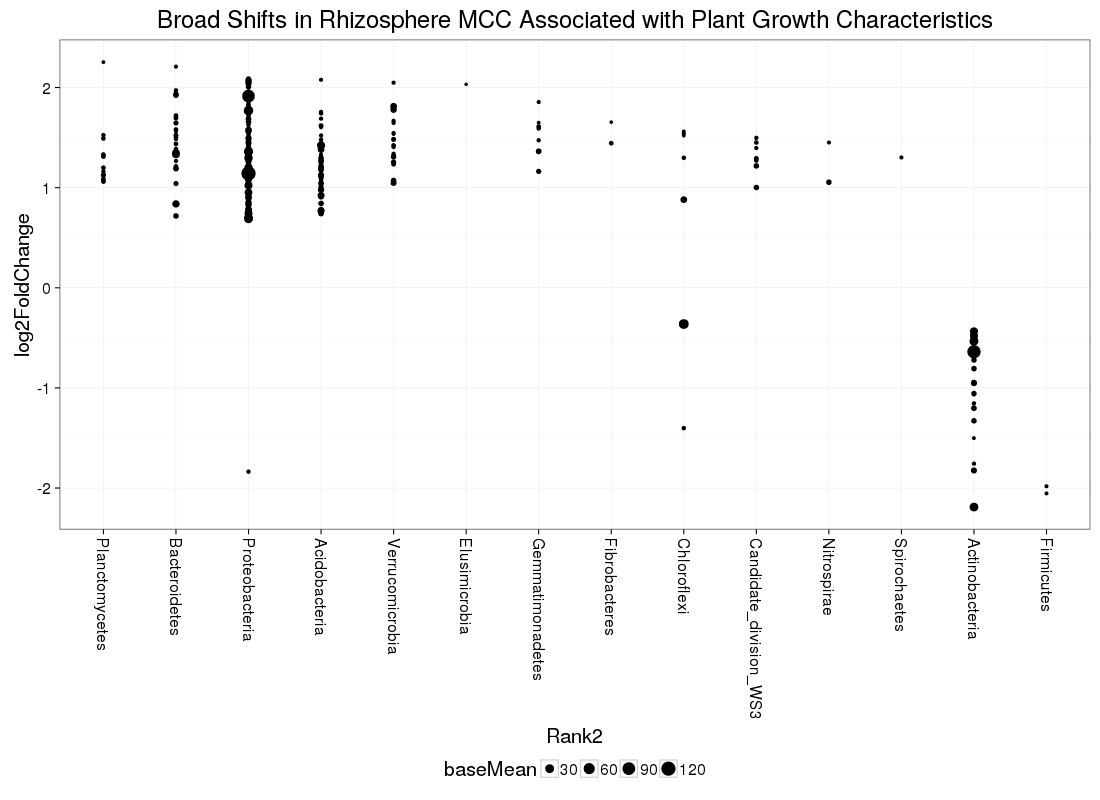

In [128]:
%%R -w 1100 -h 800
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank2, y=log2FoldChange, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("Broad Shifts in Rhizosphere MCC Associated with Plant Growth Characteristics")  +
   theme(legend.position="bottom")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [129]:
%%R
df.sig = DF[DF$padj < .05,]
levels(df.sig) = rev(levels(df.sig))
df.ns = DF[DF$padj >= .05,]

Plist = unique(df.sig$Rank2) %>% print
temp = filter(DF, Rank2 %in% Plist)
temp = filter(temp, !is.na(Rank2) & Rank2 != "Candidate_division_BRC1" & Rank2 != "Elusimicrobia" & Rank2 != "Chlorobi" & Rank2 != "Cyanobacteria")
temp$Rank2 = droplevels(temp$Rank2)
levels(temp$Rank2) %>% unique()

 [1] <NA>                   Elusimicrobia          Chloroflexi           
 [4] Acidobacteria          Gemmatimonadetes       Spirochaetes          
 [7] Verrucomicrobia        Proteobacteria         Fibrobacteres         
[10] Bacteroidetes          Nitrospirae            Candidate_division_WS3
[13] Actinobacteria         Firmicutes             Planctomycetes        
30 Levels: Acidobacteria Actinobacteria Armatimonadetes ... WCHB1-60
 [1] "Acidobacteria"          "Actinobacteria"         "Bacteroidetes"         
 [4] "Candidate_division_WS3" "Chloroflexi"            "Fibrobacteres"         
 [7] "Firmicutes"             "Gemmatimonadetes"       "Nitrospirae"           
[10] "Planctomycetes"         "Proteobacteria"         "Spirochaetes"          
[13] "Verrucomicrobia"       


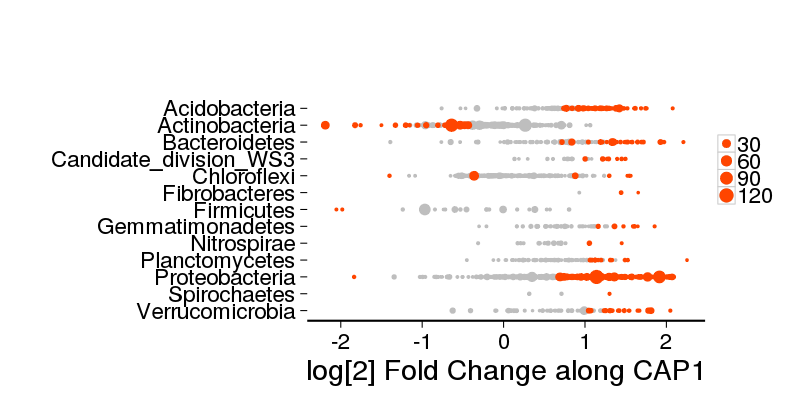

In [130]:
%%R -w 800 -h 400



p = ggplot(temp)+
    geom_point(data = df.ns, aes(log2FoldChange, Rank2, size = baseMean,  position = "jitter"), color = "Gray",) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(log2FoldChange, Rank2,  size = baseMean, position = "jitter"),
               color = "orangered") +
    theme_bw(base_size = 28) +

    scale_y_discrete(limits = rev(levels(temp$Rank2))) +
    
    
               #geom_hline(y_intercept = .4) +
    
    #theme(axis.text.x = element_text(angle = 90)) +
    labs(x = "log[2] Fold Change along CAP1") +
    labs(y = "") + 
    theme(legend.position="right", legend.title = element_blank()) +
    theme(panel.border = element_blank()) +
    theme(panel.grid = element_blank()) +
     theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_blank())
           #axis.line.y = element_line(color="black", size = 1)) 

#p = p + scale_color_manual(values = getPalette(colourCount))
p

In [43]:
%%R
# saving figure
pdf(file = "/home/bryan/RhizCG/figures/ordinations/DeSEQofCAP1.pdf", 
    height = 6, width = 15)
p %>% print
dev.off()

png 
  2 


In [165]:
%%R
CAP1.sig = CAP1 %>% filter(padj < 0.05 & log2FoldChange < 0)

## DeSEQ of CAP2

In [138]:
%%R
dds = phyloseq_to_deseq2(phy.fit, ~Library + CAP2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF_2 = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF_2))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF_2), row.names(supp)))
        }  

        DF_2 = data.frame(DF_2, supp)
        DF_2$OTU = rownames(DF_2)
DF_2$Test = "CAP2"
CAP2 = DF_2

[1] "Intercept" "Library"   "CAP2"     


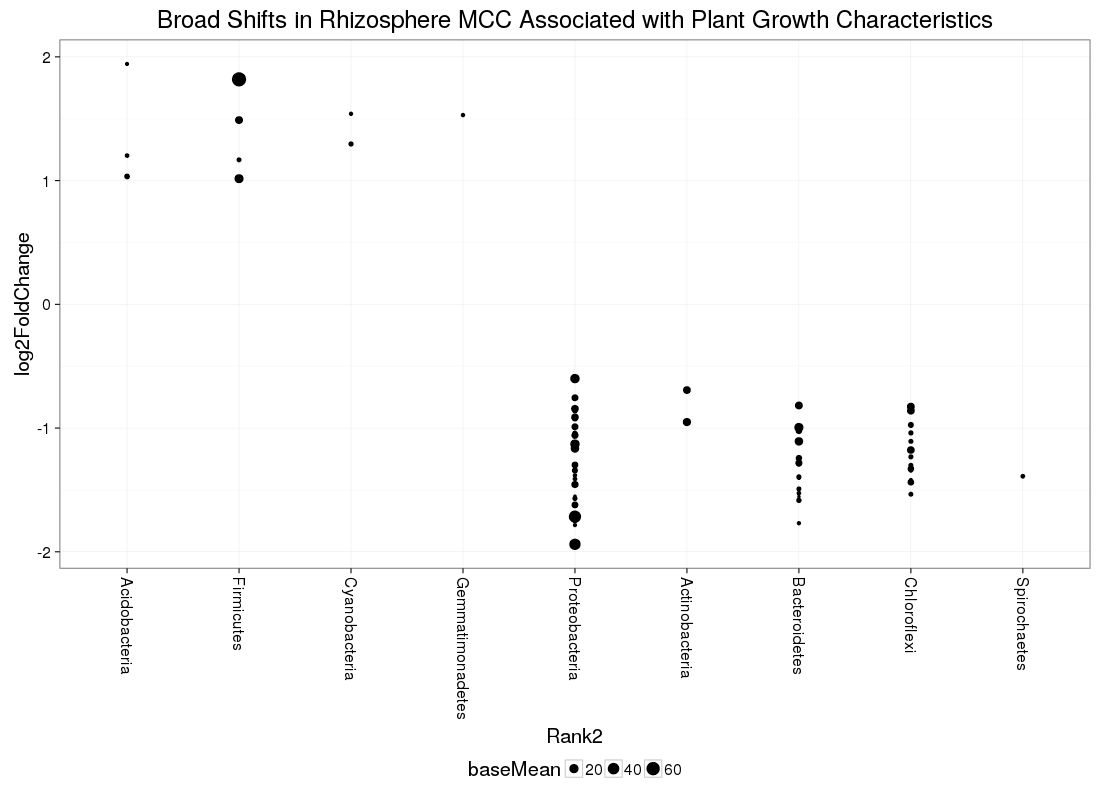

In [139]:
%%R -w 1100 -h 800
sigtab = DF_2 %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank2, y=log2FoldChange, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("Broad Shifts in Rhizosphere MCC Associated with Plant Growth Characteristics")  +
   theme(legend.position="bottom")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [142]:
%%R
DF_2.sig = DF_2[DF_2$padj < .05,]
levels(DF_2.sig) = rev(levels(DF_2.sig))
DF_2.ns = DF_2[DF_2$padj >= .05,]

Plist = unique(DF_2.sig$Rank2) %>% print
temp = filter(DF_2, Rank2 %in% Plist)
temp = filter(temp, !is.na(Rank2) & Rank2 != "Candidate_division_BRC1" & Rank2 != "Elusimicrobia" & Rank2 != "Chlorobi" & Rank2 != "Cyanobacteria")
temp$Rank2 = droplevels(temp$Rank2)
levels(temp$Rank2) %>% unique()

 [1] <NA>             Chloroflexi      Acidobacteria    Firmicutes      
 [5] Gemmatimonadetes Spirochaetes     Bacteroidetes    Cyanobacteria   
 [9] Proteobacteria   Actinobacteria  
30 Levels: Acidobacteria Actinobacteria Armatimonadetes ... WCHB1-60
[1] "Acidobacteria"    "Actinobacteria"   "Bacteroidetes"    "Chloroflexi"     
[5] "Firmicutes"       "Gemmatimonadetes" "Proteobacteria"   "Spirochaetes"    


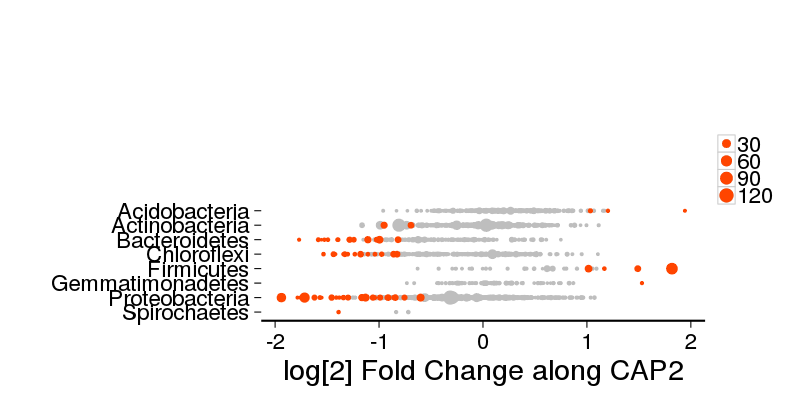

In [144]:
%%R -w 800 -h 400



p = ggplot(temp)+
    geom_point(data = DF_2.ns, aes(log2FoldChange, Rank2, size = baseMean,  position = "jitter"), color = "Gray",) +
    scale_shape_identity() +
    geom_point(data = DF_2.sig, aes(log2FoldChange, Rank2,  size = baseMean, position = "jitter"),
               color = "orangered") +
    theme_bw(base_size = 28) +

    scale_y_discrete(limits = rev(levels(temp$Rank2))) +
    
    
               #geom_hline(y_intercept = .4) +
    
    #theme(axis.text.x = element_text(angle = 90)) +
    labs(x = "log[2] Fold Change along CAP2") +
    labs(y = "") + 
    theme(legend.position="right", legend.title = element_blank()) +
    theme(panel.border = element_blank()) +
    theme(panel.grid = element_blank()) +
     theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_blank())
           #axis.line.y = element_line(color="black", size = 1)) 

#p = p + scale_color_manual(values = getPalette(colourCount))
p

In [145]:
%%R
sigtab %>% arrange(-log2FoldChange) %>% head(10)

     baseMean log2FoldChange     lfcSE     stat       pvalue         padj
1   0.5499038       1.943067 0.4283498 4.536168 5.728561e-06 1.039994e-03
2  70.4180736       1.818424 0.3429962 5.301585 1.148017e-07 4.585178e-05
3   0.7643956       1.540358 0.4349868 3.541159 3.983731e-04 1.802577e-02
4   0.8408550       1.529688 0.4389203 3.485116 4.919234e-04 2.086533e-02
5  12.1245522       1.489205 0.3624891 4.108275 3.986250e-05 4.189758e-03
6   2.1436178       1.296143 0.4107765 3.155347 1.603072e-03 4.778113e-02
7   1.1316554       1.202196 0.3677120 3.269396 1.077775e-03 3.710890e-02
8   1.6624135       1.167812 0.3579260 3.262718 1.103493e-03 3.735044e-02
9   3.3411845       1.033530 0.2974687 3.474415 5.119686e-04 2.086533e-02
10 18.8180491       1.015932 0.3179851 3.194904 1.398771e-03 4.418019e-02
      Rank1            Rank2            Rank3                Rank4
1  Bacteria    Acidobacteria            DA023 uncultured_bacterium
2  Bacteria       Firmicutes          Bacilli       

In [49]:
%%R
dim(sigtab)

[1] 68 16


# Save results tables for use in other notebooks

In [50]:
%%R
head(DF)

           baseMean log2FoldChange     lfcSE        stat    pvalue padj
OTU.4087 0.02319558     0.07522368 0.4076284  0.18453985 0.8535900   NA
OTU.2009 0.08314549     0.02913032 0.4805717  0.06061597 0.9516651   NA
OTU.5899 0.05009856     0.02587619 0.4076284  0.06347986 0.9493844   NA
OTU.4181 0.00000000             NA        NA          NA        NA   NA
OTU.3052 0.06320591     0.24146441 0.4127238  0.58505080 0.5585136   NA
OTU.1890 0.17867000    -0.45143446 0.5801950 -0.77807367 0.4365256   NA
            Rank1         Rank2                Rank3                     Rank4
OTU.4087 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.2009 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.5899 Bacteria Acidobacteria                32-21      uncultured_bacterium
OTU.4181 Bacteria Elusimicrobia          Lineage_IIa      uncultured_bacterium
OTU.3052 Bacteria Elusimicrobia          Lineage_IIa uncultured_soil_bacterium
OTU.1890 Bacteria Elus

In [51]:
%%R
CAP = rbind(CAP1, CAP2)

CAP$direction = ifelse(CAP$log2FoldChange >= 0, "Pos", "Neg")

head(CAP)

           baseMean log2FoldChange     lfcSE        stat    pvalue padj
OTU.4087 0.02319558     0.07522368 0.4076284  0.18453985 0.8535900   NA
OTU.2009 0.08314549     0.02913032 0.4805717  0.06061597 0.9516651   NA
OTU.5899 0.05009856     0.02587619 0.4076284  0.06347986 0.9493844   NA
OTU.4181 0.00000000             NA        NA          NA        NA   NA
OTU.3052 0.06320591     0.24146441 0.4127238  0.58505080 0.5585136   NA
OTU.1890 0.17867000    -0.45143446 0.5801950 -0.77807367 0.4365256   NA
            Rank1         Rank2                Rank3                     Rank4
OTU.4087 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.2009 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.5899 Bacteria Acidobacteria                32-21      uncultured_bacterium
OTU.4181 Bacteria Elusimicrobia          Lineage_IIa      uncultured_bacterium
OTU.3052 Bacteria Elusimicrobia          Lineage_IIa uncultured_soil_bacterium
OTU.1890 Bacteria Elus

In [52]:
%%R
write.table(CAP, file = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/CAP_responders.txt', sep = "\t")


# Is constrained ordination correlated with enzymes?

In [148]:
%%R
temp = sample_data(phy.fit)
#rcorr(as.matrix(temp[,c("B", "Biomass_P", "DAP", "Plant_CN", "SeedSize_mg")]))
#rcorr(as.matrix(temp[,c("PC1", "PC2", "PC3", "BX_activity_g", "CB_activity_g", "LAP_activity_g", "NAG_activity_g", "InorganicN")]))

rcorr(as.matrix(temp[,c("CAP1", "CAP2", "BX_activity_g", "CB_activity_g", "LAP_activity_g", "NAG_activity_g", "InorganicN")]))

                CAP1  CAP2 BX_activity_g CB_activity_g LAP_activity_g
CAP1            1.00 -0.23         -0.38         -0.26          -0.55
CAP2           -0.23  1.00          0.51          0.53           0.10
BX_activity_g  -0.38  0.51          1.00          0.81           0.69
CB_activity_g  -0.26  0.53          0.81          1.00           0.36
LAP_activity_g -0.55  0.10          0.69          0.36           1.00
NAG_activity_g -0.29 -0.14          0.12          0.11           0.27
InorganicN      0.35 -0.11         -0.18         -0.04          -0.42
               NAG_activity_g InorganicN
CAP1                    -0.29       0.35
CAP2                    -0.14      -0.11
BX_activity_g            0.12      -0.18
CB_activity_g            0.11      -0.04
LAP_activity_g           0.27      -0.42
NAG_activity_g           1.00       0.26
InorganicN               0.26       1.00

n
               CAP1 CAP2 BX_activity_g CB_activity_g LAP_activity_g
CAP1             47   47            47   

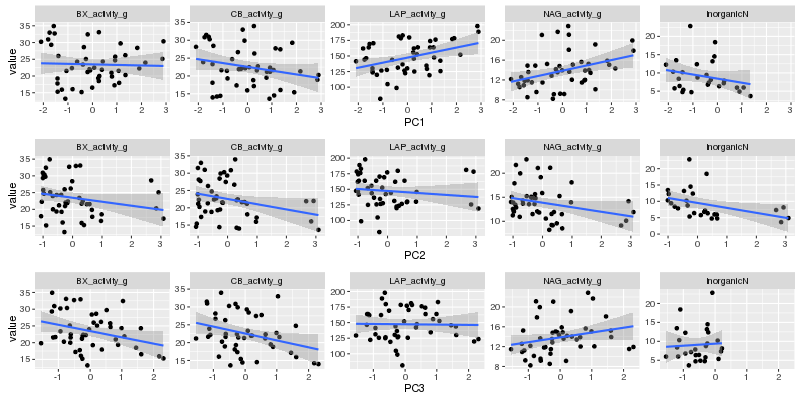

In [115]:
%%R -w 800 -h 400
t2 = temp[,c("Plant", "Type", "PC1", "PC2", "PC3", "BX_activity_g", "CB_activity_g", "LAP_activity_g", "NAG_activity_g", "InorganicN")]
p = t2 %>% 
    melt(id = c("Plant", "Type", "PC1", "PC2", "PC3")) %>%
         ggplot(aes(x = PC1, y = value)) +
        geom_point() +
        facet_wrap(~variable, ncol = 5, scales = "free_y") +
        stat_smooth(method = "lm")
p1 = t2 %>% 
    melt(id = c("Plant", "Type", "PC1", "PC2", "PC3")) %>%
         ggplot(aes(x = PC2, y = value)) +
        geom_point() +
        facet_wrap(~variable, ncol = 5, scales = "free_y") + 
        stat_smooth(method = "lm")
p2 = t2 %>% 
    melt(id = c("Plant", "Type", "PC1", "PC2", "PC3")) %>%
         ggplot(aes(x = PC3, y = value)) +
        geom_point() +
        facet_wrap(~variable, ncol = 5, scales = "free_y") + 
        stat_smooth(method = "lm")
grid.arrange(p, p1, p2, ncol = 1)

# Check is LAP directly correlated with similar OTUs

In [152]:
%%R
dds = phyloseq_to_deseq2(phy.fit, ~LAP_activity_g)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.fit)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
DF$Test = "LAP"
LAP = DF



[1] "Intercept"      "LAP_activity_g"


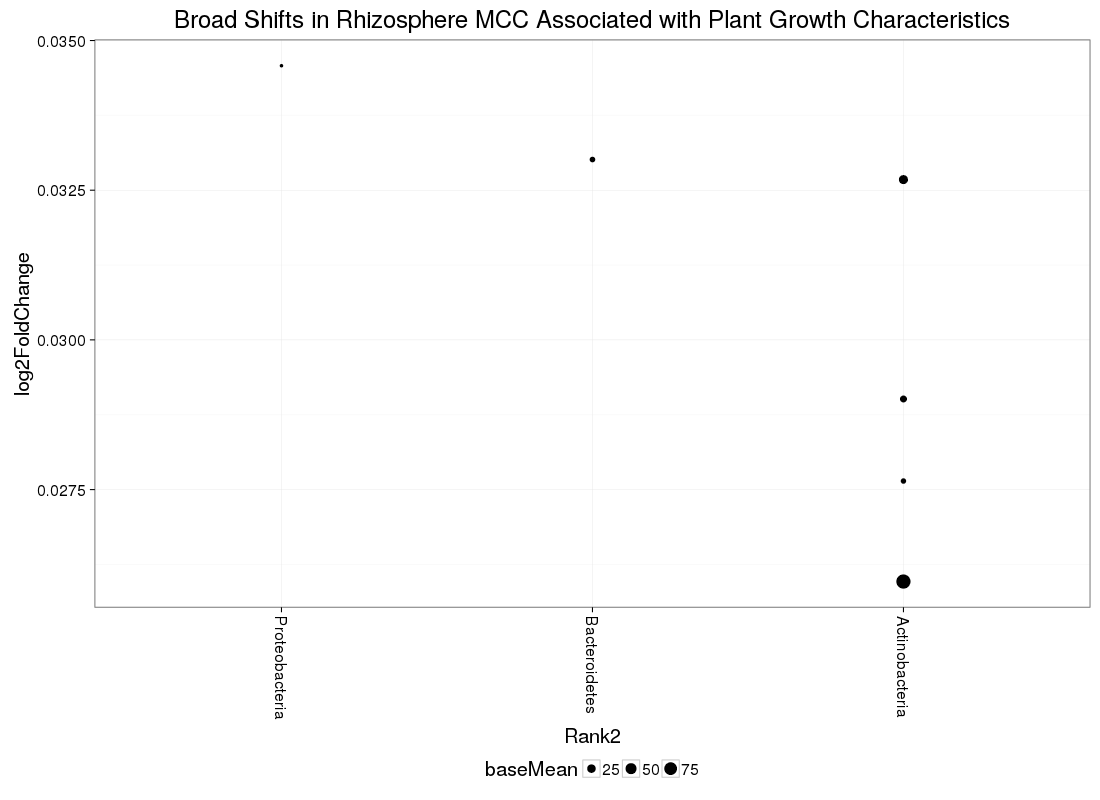

In [155]:
%%R -w 1100 -h 800
sigtab = LAP %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank2, y=log2FoldChange, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("Broad Shifts in Rhizosphere MCC Associated with Plant Growth Characteristics")  +
   theme(legend.position="bottom")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [181]:
%%R
LAP.sig = LAP[LAP$padj < .05,]
levels(LAP.sig) = rev(levels(LAP.sig))
LAP.ns = LAP[LAP$padj >= .05,]

Plist = unique(LAP.sig$Rank2) %>% print
temp = filter(LAP, Rank2 %in% Plist)
temp = filter(temp, !is.na(Rank2) & Rank2 != "Candidate_division_BRC1" & Rank2 != "Elusimicrobia" & Rank2 != "Chlorobi" & Rank2 != "Cyanobacteria")
temp$Rank2 = droplevels(temp$Rank2)
levels(temp$Rank2) %>% unique()

[1] <NA>           Bacteroidetes  Proteobacteria Actinobacteria
30 Levels: Acidobacteria Actinobacteria Armatimonadetes ... WCHB1-60
[1] "Actinobacteria" "Bacteroidetes"  "Proteobacteria"


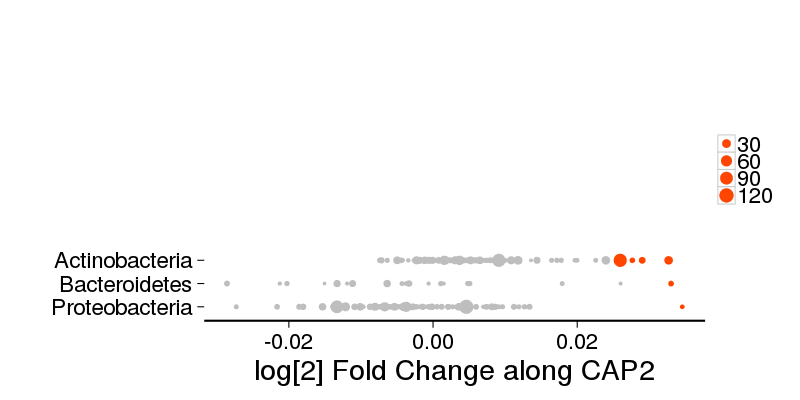

In [182]:
%%R -w 800 -h 400



p = ggplot(temp)+
    geom_point(data = LAP.ns, aes(log2FoldChange, Rank2, size = baseMean,  position = "jitter"), color = "Gray",) +
    scale_shape_identity() +
    geom_point(data = LAP.sig, aes(log2FoldChange, Rank2,  size = baseMean, position = "jitter"),
               color = "orangered") +
    theme_bw(base_size = 28) +

    scale_y_discrete(limits = rev(levels(temp$Rank2))) +
    
    
               #geom_hline(y_intercept = .4) +
    
    #theme(axis.text.x = element_text(angle = 90)) +
    labs(x = "log[2] Fold Change along CAP2") +
    labs(y = "") + 
    theme(legend.position="right", legend.title = element_blank()) +
    theme(panel.border = element_blank()) +
    theme(panel.grid = element_blank()) +
     theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_blank())
           #axis.line.y = element_line(color="black", size = 1)) 

#p = p + scale_color_manual(values = getPalette(colourCount))
p

In [183]:
%%R
LAP.sig = filter(LAP.sig, !is.na(padj))
LAP.sig

   baseMean log2FoldChange       lfcSE     stat       pvalue       padj
1  7.970296     0.03301268 0.007721989 4.275152 1.910067e-05 0.00653243
2  4.252196     0.03457978 0.009425767 3.668643 2.438409e-04 0.02084840
3  7.416459     0.02764333 0.007976820 3.465457 5.293313e-04 0.03017188
4 14.044042     0.02901369 0.007619304 3.807919 1.401409e-04 0.02084840
5 29.308460     0.03267791 0.008769954 3.726121 1.944494e-04 0.02084840
6 99.267945     0.02596503 0.007366584 3.524704 4.239562e-04 0.02899861
     Rank1          Rank2               Rank3                 Rank4
1 Bacteria  Bacteroidetes          Cytophagia          Cytophagales
2 Bacteria Proteobacteria Alphaproteobacteria      Sphingomonadales
3 Bacteria Actinobacteria       Micrococcales Promicromonosporaceae
4 Bacteria Actinobacteria   Pseudonocardiales    Pseudonocardiaceae
5 Bacteria Actinobacteria   Pseudonocardiales    Pseudonocardiaceae
6 Bacteria Actinobacteria   Pseudonocardiales    Pseudonocardiaceae
              Rank5 

In [ ]:
## Are CB OTUs the same as Cap2

In [172]:
%%R
dds = phyloseq_to_deseq2(phy.fit, ~CB_activity_g)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.fit)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
DF$Test = "CB"
CB = DF



[1] "Intercept"     "CB_activity_g"


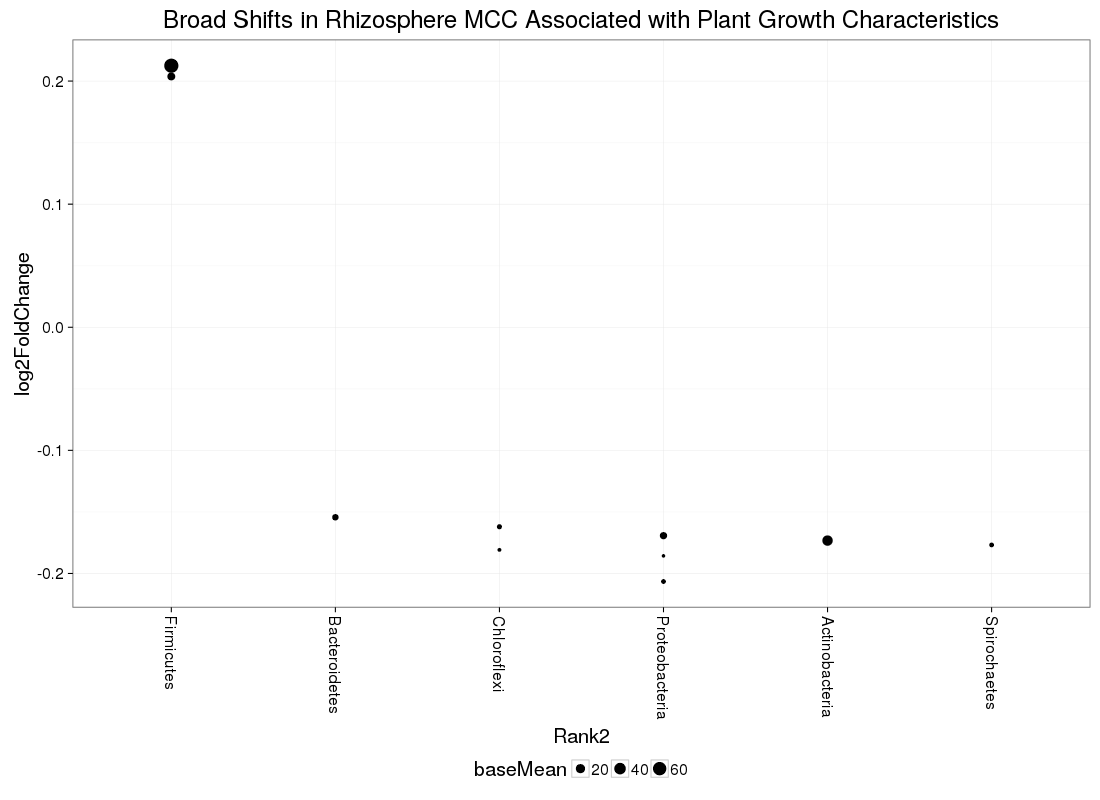

In [176]:
%%R -w 1100 -h 800
sigtab = CB %>% filter(padj < 0.05)
CB.sig = filter(sigtab, log2FoldChange > 0)

x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank2, y=log2FoldChange, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("Broad Shifts in Rhizosphere MCC Associated with Plant Growth Characteristics")  +
   theme(legend.position="bottom")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

### set tables dif

In [184]:
%%R
LAPCAP1 = inner_join(CAP1.sig, LAP.sig, by = "OTU")
LAPCAP1

  baseMean.x log2FoldChange.x   lfcSE.x    stat.x     pvalue.x       padj.x
1   7.416459        -1.824308 0.3788448 -4.815448 1.468698e-06 0.0001142217
   Rank1.x        Rank2.x       Rank3.x               Rank4.x           Rank5.x
1 Bacteria Actinobacteria Micrococcales Promicromonosporaceae Promicromonospora
  Rank6.x Rank7.x Rank8.x     OTU Test.x baseMean.y log2FoldChange.y    lfcSE.y
1    <NA>    <NA>    <NA> OTU.200   CAP1   7.416459       0.02764333 0.00797682
    stat.y     pvalue.y     padj.y  Rank1.y        Rank2.y       Rank3.y
1 3.465457 0.0005293313 0.03017188 Bacteria Actinobacteria Micrococcales
                Rank4.y           Rank5.y Rank6.y Rank7.y Rank8.y Test.y
1 Promicromonosporaceae Promicromonospora    <NA>    <NA>    <NA>    LAP


In [180]:
%%R
CAP2.sig = filter(CAP2, padj < 0.05 & log2FoldChange > 0)

CBCAP2 = inner_join(CAP2.sig, CB.sig, by = "OTU")
CBCAP2

  baseMean.x log2FoldChange.x   lfcSE.x   stat.x     pvalue.x       padj.x
1   70.41807         1.818424 0.3429962 5.301585 1.148017e-07 4.585178e-05
2   12.12455         1.489205 0.3624891 4.108275 3.986250e-05 4.189758e-03
   Rank1.x    Rank2.x Rank3.x    Rank4.x     Rank5.x  Rank6.x
1 Bacteria Firmicutes Bacilli Bacillales Bacillaceae Bacillus
2 Bacteria Firmicutes Bacilli Bacillales Bacillaceae Bacillus
              Rank7.x Rank8.x    OTU Test.x baseMean.y log2FoldChange.y
1 Bacillus_megaterium    <NA> OTU.20   CAP2   70.41807        0.2125108
2     Bacillus_cereus    <NA> OTU.84   CAP2   12.12455        0.2037618
     lfcSE.y   stat.y     pvalue.y      padj.y  Rank1.y    Rank2.y Rank3.y
1 0.04205847 5.052747 4.355015e-07 0.001070027 Bacteria Firmicutes Bacilli
2 0.04190237 4.862777 1.157505e-06 0.001421994 Bacteria Firmicutes Bacilli
     Rank4.y     Rank5.y  Rank6.y             Rank7.y Rank8.y Test.y
1 Bacillales Bacillaceae Bacillus Bacillus_megaterium    <NA>     CB
2 Bacillal

# Maize

In [199]:
%%R
phy = subset_samples(physeq.Full, Type == "Maize" & Treatment == "Nneg")

In [200]:
%%R
#add seed size
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, 264, 224, 219, 279, 207,
               240, 87, 222, 228, 231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric



# # PCA of annuals
sd = as(sample_data(phy), "data.frame")
sd$Plant %>% levels %>% print
sd = left_join(sd, SS, by = "Plant")

rownames(sd) = sd$X.sample
rownames(sd)
sample_data(phy) = sd 

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
 [1] "75-062" "B73"    "B97"    "H99"    "Hp301"  "Il14H"  "Ki3"    "Mo18"  
 [9] "MS71"   "Oh7B"   "Tx303" 


In [201]:
%%R
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 44 samples ]
sample_data() Sample Data:       [ 44 samples by 56 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [202]:
%%R
registerDoParallel(cores=28)
maize.wunif.dist = distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [203]:
%%R
sample_data(phy)$SeedSize_mg

 [1] 222 222 264 333 333 264 264 264 222 207 240 231 207 219 207 222 240 231 207
[20] 231 333 333 240 219 219 240 231 219 228  87 228  87 279 224 279 224 224 279
[39] 228 279  87 228  87 224


[1] 72 79 88


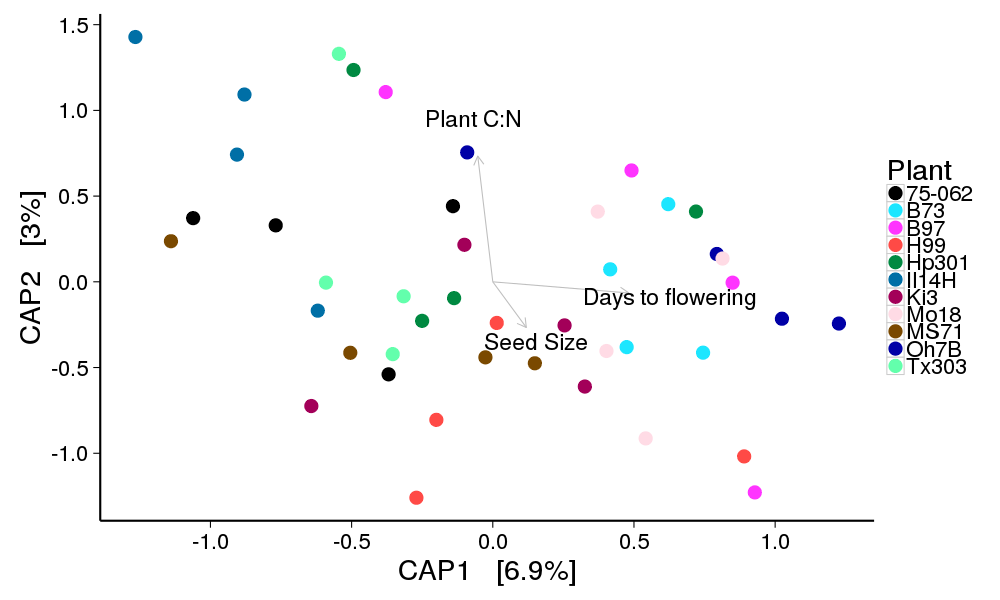

In [205]:
%%R -w 1000 -h 600

sample_data(phy)$DAP = sample_data(phy)$DAP %>% as.character() %>% as.numeric()
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = maize.wunif.dist,
    formula = ~  M_Resid_logCN + DAP + SeedSize_mg + Condition(Library)
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    #aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 6) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    
    scale_color_manual(values = c("#000000", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80")) 
    
    #ggtitle("Plant Function")

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")

rownames(arrowmat) = c("Plant C:N", "Days to flowering", "Seed Size")

# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
p = cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 8,  
    data = arrowdf, 
    show_guide = FALSE) +
theme_bw(base_size = 28) +
    theme(legend.position="right") +
    theme(panel.border = element_blank()) +
    theme(panel.grid = element_blank())+
    theme(axis.line.x = element_line(color="black", size = 1),
    axis.line.y = element_line(color="black", size = 1)) 
p

In [206]:
%%R
anova(cap.ord)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ M_Resid_logCN + DAP + SeedSize_mg + Condition(Library), data = data)
         Df SumOfSqs      F Pr(>F)  
Model     3  0.10173 1.6557  0.042 *
Residual 39  0.79871                
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [208]:
%%R
# Check that rownames match
row.names(cap.plot$data)[1:5] %>% print
sample_data(phy) %>% row.names() %>% .[1:5]

[1] "sample5-1.22_Nneg" "sample5-2.29_Nneg" "sample5-2.06_Nneg"
[4] "sample6-2.26_Nneg" "sample6-3.18_Nneg"
[1] "sample5-1.22_Nneg" "sample5-2.29_Nneg" "sample5-2.06_Nneg"
[4] "sample6-2.26_Nneg" "sample6-3.18_Nneg"


In [207]:
%%R
sample_data(phy)$CAP1 = cap.plot$data$CAP1
sample_data(phy)$CAP2 = cap.plot$data$CAP2
head(sample_data(phy))

Sample Data:        [6 samples by 58 sample variables]:
                           X.sample Library Primer_Plate Primer_Well_ID
sample5-1.22_Nneg sample5-1.22_Nneg       1            1             A4
sample5-2.29_Nneg sample5-2.29_Nneg       1            1             C4
sample5-2.06_Nneg sample5-2.06_Nneg       1            2             C1
sample6-2.26_Nneg sample6-2.26_Nneg       1            2             C7
sample6-3.18_Nneg sample6-3.18_Nneg       1            2             E7
sample5-3.13_Nneg sample5-3.13_Nneg       1            2             E1
                  primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
sample5-1.22_Nneg                  25                25         25 1.22_Nneg
sample5-2.29_Nneg                  27                27         27 2.29_Nneg
sample5-2.06_Nneg                   3                99         99 2.06_Nneg
sample6-2.26_Nneg                  51               147        147 2.26_Nneg
sample6-3.18_Nneg                  53               149

In [209]:
%%R
dds = phyloseq_to_deseq2(phy, ~CAP1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.fit)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
DF$Test = "CB"
MaizeCAP1 = DF



/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept" "CAP1"     


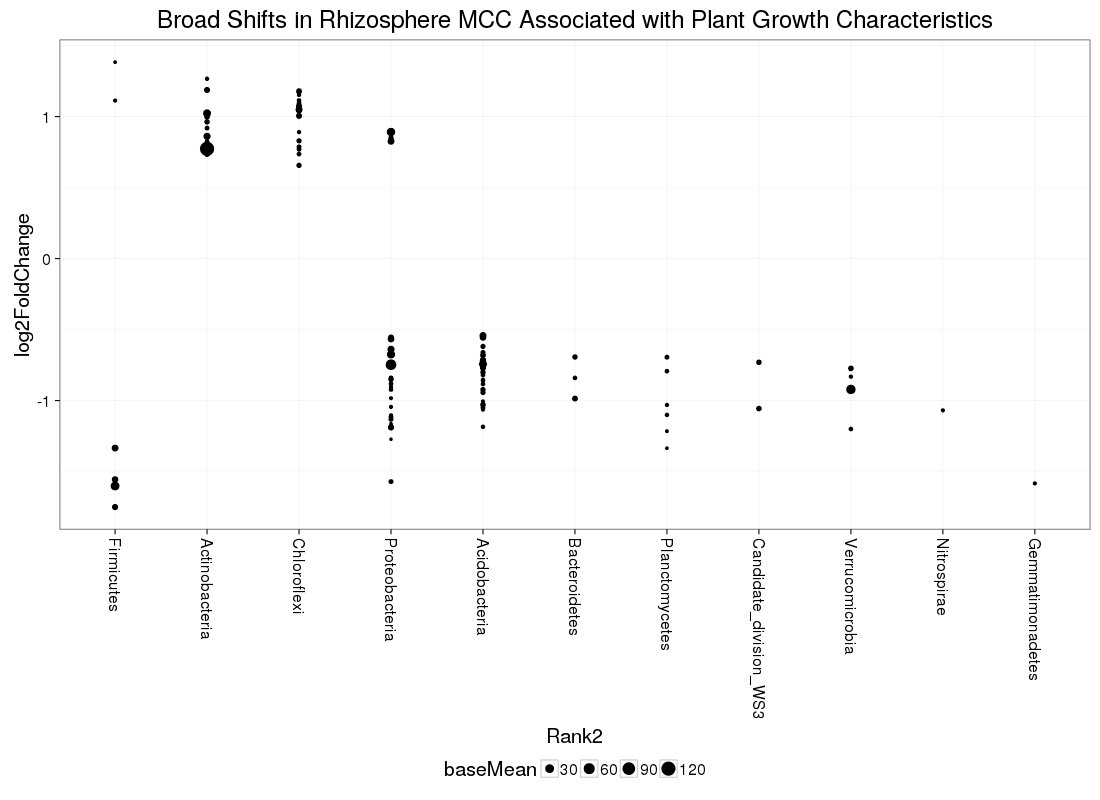

In [210]:
%%R -w 1100 -h 800
sigtab = MaizeCAP1 %>% filter(padj < 0.05)
#CB.sig = filter(sigtab, log2FoldChange > 0)

x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank2, y=log2FoldChange, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("Broad Shifts in Rhizosphere MCC Associated with Plant Growth Characteristics")  +
   theme(legend.position="bottom")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [215]:
%%R
MaizeCAP1 %>% filter(padj < 0.05 & log2FoldChange > 0)

      baseMean log2FoldChange     lfcSE     stat       pvalue         padj
1    4.1475588      0.6566963 0.2169542 3.026889 2.470848e-03 3.179874e-02
2    1.5040232      1.1528941 0.3255879 3.540961 3.986722e-04 9.409366e-03
3    4.8203376      1.0617277 0.2522486 4.209053 2.564428e-05 1.320123e-03
4    2.5218083      0.7367947 0.2449717 3.007672 2.632569e-03 3.315916e-02
5    1.5860075      1.0946025 0.3358552 3.259150 1.117465e-03 1.945703e-02
6    2.7123304      0.7871803 0.2616121 3.008959 2.621443e-03 3.315916e-02
7    2.4382933      0.7700674 0.2607984 2.952731 3.149767e-03 3.766994e-02
8    8.1465000      1.0718284 0.1895517 5.654545 1.562597e-08 9.250573e-06
9    3.0629981      1.0035418 0.2482211 4.042936 5.278608e-05 2.155128e-03
10   6.3826372      1.1795643 0.3045948 3.872569 1.076941e-04 3.643138e-03
11   1.8515292      1.0356348 0.3158278 3.279112 1.041344e-03 1.868108e-02
12   3.6664592      1.1738403 0.2627099 4.468200 7.888068e-06 6.671051e-04
13   1.3622494      0.890

In [211]:
%%R
dds = phyloseq_to_deseq2(phy, ~CAP2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
DF$Test = "CAP2"
MaizeCAP2 = DF



[1] "Intercept" "CAP2"     


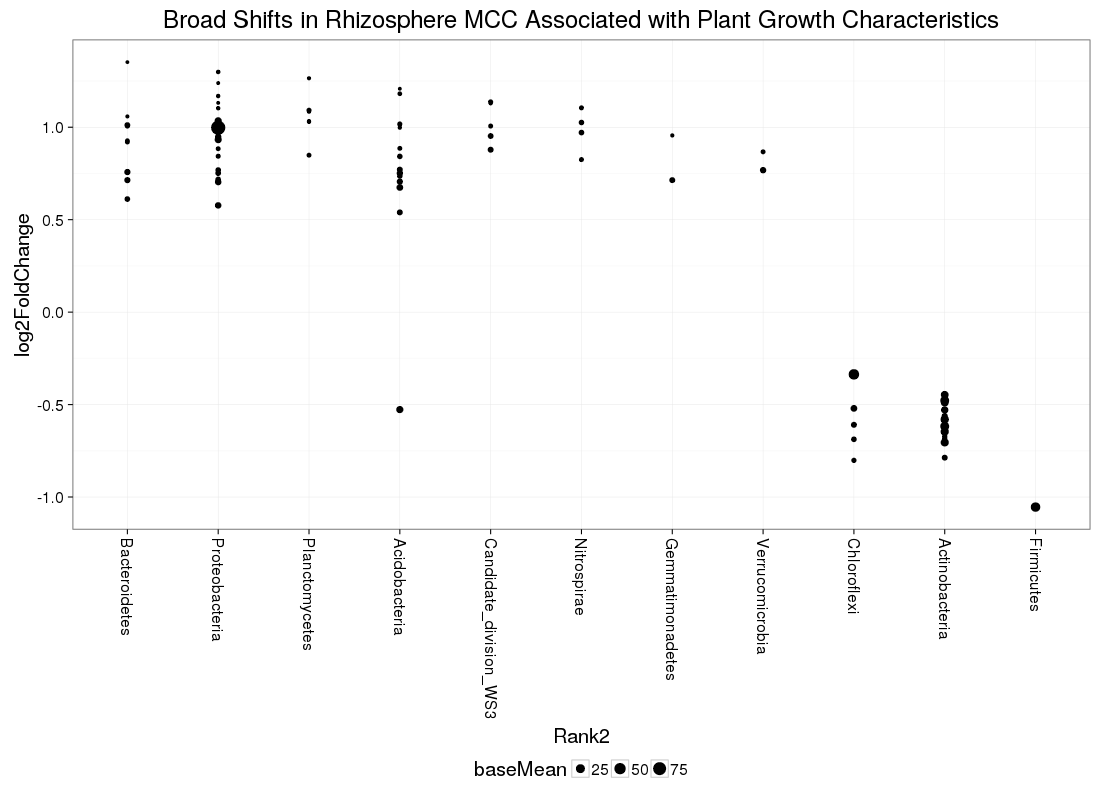

In [212]:
%%R -w 1100 -h 800
sigtab = MaizeCAP2 %>% filter(padj < 0.05)
#CB.sig = filter(sigtab, log2FoldChange > 0)

x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank2, y=log2FoldChange, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("Broad Shifts in Rhizosphere MCC Associated with Plant Growth Characteristics")  +
   theme(legend.position="bottom")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [214]:
%%R
MaizeCAP2 %>% filter(padj < 0.05 & log2FoldChange < 0)

    baseMean log2FoldChange     lfcSE      stat       pvalue        padj
1   5.600762     -0.6091329 0.1810443 -3.364551 7.666836e-04 0.024691266
2  39.773303     -0.3362977 0.1020200 -3.296389 9.793648e-04 0.027351054
3   4.147559     -0.6877131 0.2169741 -3.169563 1.526683e-03 0.032142863
4   2.967537     -0.8013589 0.2516440 -3.184495 1.450069e-03 0.031635151
5   9.333282     -0.5203806 0.1731381 -3.005581 2.650742e-03 0.048021584
6  29.511062     -1.0541772 0.3482625 -3.026962 2.470251e-03 0.046104342
7   6.405412     -0.5621660 0.1665138 -3.376092 7.352324e-04 0.024691266
8   4.806002     -0.6150192 0.2033072 -3.025073 2.485728e-03 0.046104342
9   3.079683     -0.6706038 0.2206796 -3.038812 2.375127e-03 0.045451405
10 15.089967     -0.4896531 0.1291099 -3.792529 1.491206e-04 0.011531469
11 23.845593     -0.4778088 0.1371153 -3.484723 4.926458e-04 0.021320617
12 15.266095     -0.4469520 0.1368243 -3.266613 1.088424e-03 0.027351054
13 11.644162     -0.5268884 0.1465533 -3.595201 3.2

In [213]:
%%R
temp = sample_data(phy)
#rcorr(as.matrix(temp[,c("B", "Biomass_P", "DAP", "Plant_CN", "SeedSize_mg")]))
#rcorr(as.matrix(temp[,c("PC1", "PC2", "PC3", "BX_activity_g", "CB_activity_g", "LAP_activity_g", "NAG_activity_g", "InorganicN")]))

rcorr(as.matrix(temp[,c("CAP1", "CAP2", "BX_activity_g", "CB_activity_g", "LAP_activity_g", "NAG_activity_g", "InorganicN")]))

                CAP1  CAP2 BX_activity_g CB_activity_g LAP_activity_g
CAP1            1.00 -0.39          0.18          0.16           0.21
CAP2           -0.39  1.00         -0.11         -0.13          -0.04
BX_activity_g   0.18 -0.11          1.00          0.85           0.70
CB_activity_g   0.16 -0.13          0.85          1.00           0.54
LAP_activity_g  0.21 -0.04          0.70          0.54           1.00
NAG_activity_g  0.19  0.09          0.35          0.10           0.29
InorganicN     -0.07 -0.27         -0.21         -0.13          -0.23
               NAG_activity_g InorganicN
CAP1                     0.19      -0.07
CAP2                     0.09      -0.27
BX_activity_g            0.35      -0.21
CB_activity_g            0.10      -0.13
LAP_activity_g           0.29      -0.23
NAG_activity_g           1.00      -0.06
InorganicN              -0.06       1.00

n
               CAP1 CAP2 BX_activity_g CB_activity_g LAP_activity_g
CAP1             44   44            44   

# Annuals 

## Late Season Annuals - PCA of growth residuals

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
NULL
Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.4973 1.1837 0.59627 0.03612
Proportion of Variance 0.5605 0.3503 0.08888 0.00033
Cumulative Proportion  0.5605 0.9108 0.99967 1.00000
                        PC1         PC2        PC3         PC4
log(SeedSize_mg) -0.5549666  0.24710822 -0.7936365 -0.03302717
A_Resid_logB     -0.6461202 -0.05649449  0.4074687  0.64288904
A_Resid_logN     -0.4687695 -0.59539147  0.1686459 -0.63033538
A_Resid_logCN    -0.2340853  0.76240075  0.4191288 -0.43391266


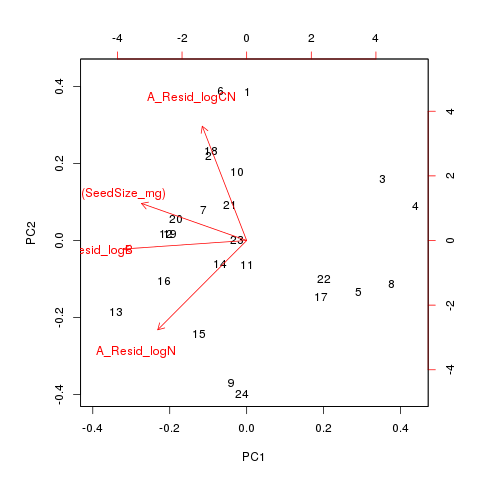

In [6]:
%%R
# PCA of annuals



# subset of plants for which functional variation was significant
LS = subset_samples(phy, Treatment == "Nneg" & Plant %in% c("B73",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN") )


# Add seed size information
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
                    
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)


SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric


sd = as(sample_data(LS), "data.frame")

sd = left_join(sd, SS, by = "Plant")

sd$Plant %>% levels %>% print


fit = prcomp(~log(SeedSize_mg) + A_Resid_logB + A_Resid_logN + A_Resid_logCN, data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)





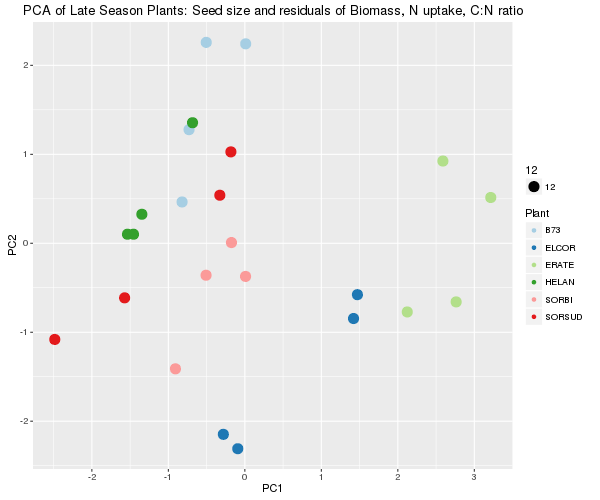

In [12]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(LS) = TM_Fit



p = ggplot(TM_Fit, aes(PC1, PC2, colour = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Late Season Plants: Seed size and residuals of Biomass, N uptake, C:N ratio")
p

Notes: 
    * PC2 represents residual C:N ratio once plant size, total N uptake and seed size are controlled for
    * Species effect apparent in both PC1 and PC2

## Annuals CAP with growth residuals

In [9]:
%%R
# Calculate w-unifrac distances
registerDoParallel(cores=28)
LS.wunif.dist = phyloseq::distance(LS, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


[1] 79 72 88 84
Levels: 72 79 84 88
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ log(SeedSize_mg) + A_Resid_logN + A_Resid_logB + A_Resid_logCN + Condition(Library), data = data)
         Df SumOfSqs      F Pr(>F)    
Model     4  0.38144 4.0014  0.001 ***
Residual 18  0.42897                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


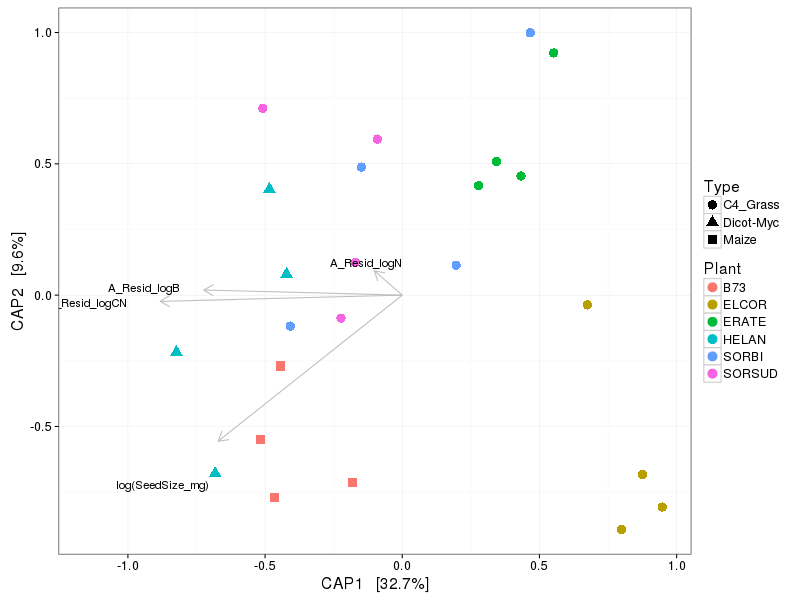

In [151]:
%%R -w 800 -h 600

dist = LS.wunif.dist

sample_data(LS)$DAP = as.factor(sample_data(LS)$DAP)
unique(sample_data(LS)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = LS, 
            method = "CAP",
            distance = dist,
            formula = ~ log(SeedSize_mg) +  A_Resid_logN + A_Resid_logB + A_Resid_logCN + Condition(Library)

        )

        # CAP plot
        cap.plot <- plot_ordination(
            LS, 
            cap.ord, 
            color = "Plant", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(colour = Plant), 
                alpha= 1, 
                size = 4) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p1 = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p1


In [152]:
%%R
# Check that rownames match
row.names(cap.plot$data)[1:5] %>% print
sample_data(LS) %>% row.names() %>% .[1:5]

[1] "sample6-2.26_Nneg" "sample6-3.18_Nneg" "sample5-3.11_Nneg"
[4] "sample5-4.06_Nneg" "sample5-2.18_Nneg"
[1] "sample6-2.26_Nneg" "sample6-3.18_Nneg" "sample5-3.11_Nneg"
[4] "sample5-4.06_Nneg" "sample5-2.18_Nneg"


In [153]:
%%R
sample_data(LS)$CAP1 = cap.plot$data$CAP1
#head(sample_data(phy))

## DeSEQ of CAP1

In [154]:
%%R
dds = phyloseq_to_deseq2(LS, ~Library + CAP1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(LS)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "CAP1"     


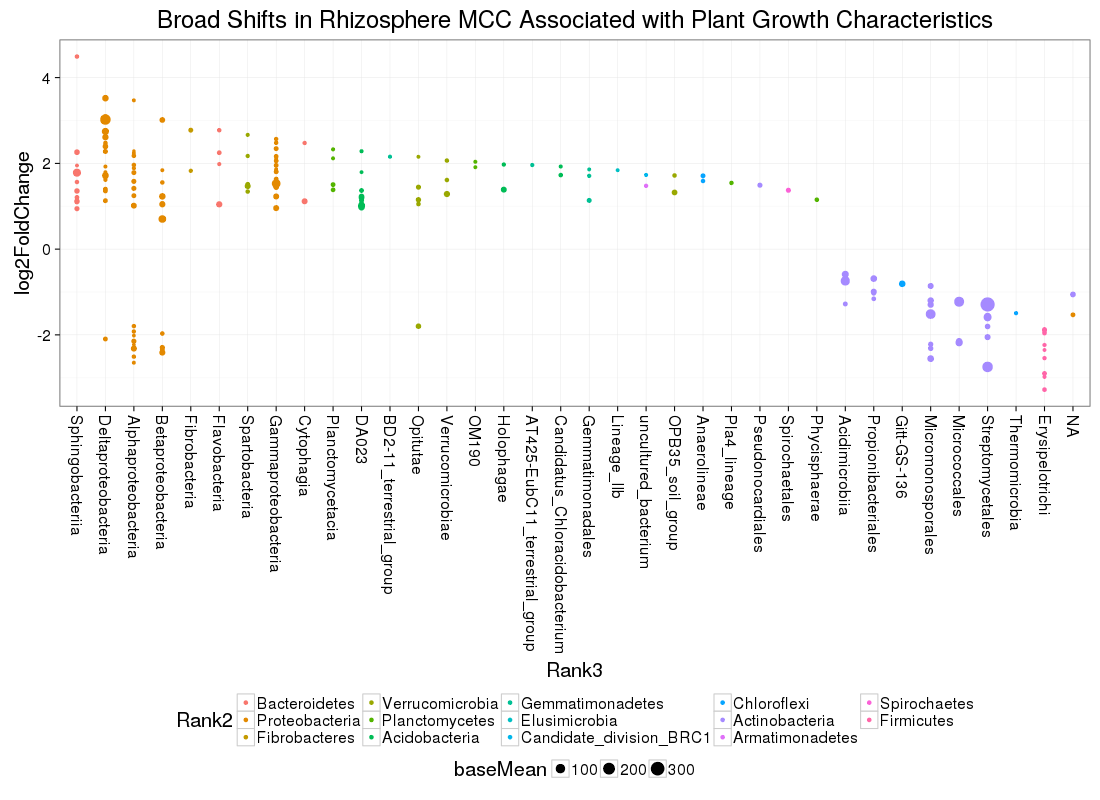

In [155]:
%%R -w 1100 -h 800
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank3, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("Broad Shifts in Rhizosphere MCC Associated with Plant Growth Characteristics")  +
   theme(legend.position="bottom")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

Notes:
* PC1 and PC2 describes 15.7% of variation in microbial community weighted unifrac distance
* CAP analysis is significant p < 0.001

## Try CAP with Enzyme info as well

[1] 79 72 88 84
Levels: 72 79 84 88
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ PC1 + PC2 + PC3 + Condition(Library), data = data)
         Df SumOfSqs      F Pr(>F)    
Model     3  0.33375 4.4347  0.001 ***
Residual 19  0.47665                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


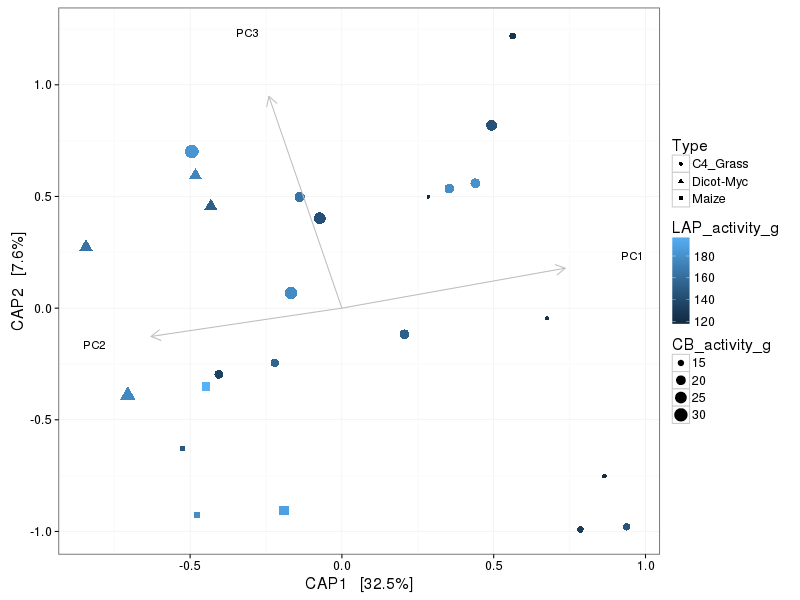

In [30]:
%%R -w 800 -h 600

dist = LS.wunif.dist

sample_data(LS)$DAP = as.factor(sample_data(LS)$DAP)
unique(sample_data(LS)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = LS, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + PC3 + Condition(Library)
        )

        # CAP plot
        cap.plot <- plot_ordination(
            LS, 
            cap.ord, 
            color = "LAP_activity_g", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(fill = LAP_activity_g, size = CB_activity_g), 
                alpha= 1) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p1 = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p1

## How does unconstrained PCoA place these microbial communities

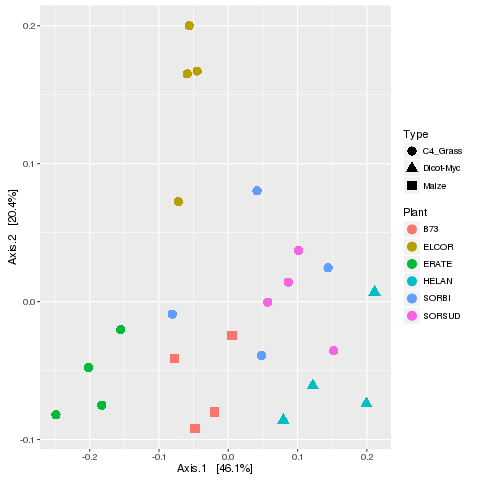

In [37]:
%%R
ordu = ordinate(LS, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(LS, ordu, color="Plant", shape="Type") 
p = p + geom_point(size = 4)
p

##  Late Season Annuals Deseq of PC2
* Identify OTUs that vary with PC2

In [11]:
%%R
dds = phyloseq_to_deseq2(LS, ~Library + PC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(LS)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating size factors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating dispersions

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/fu

[1] "Intercept" "Library"   "PC1"      


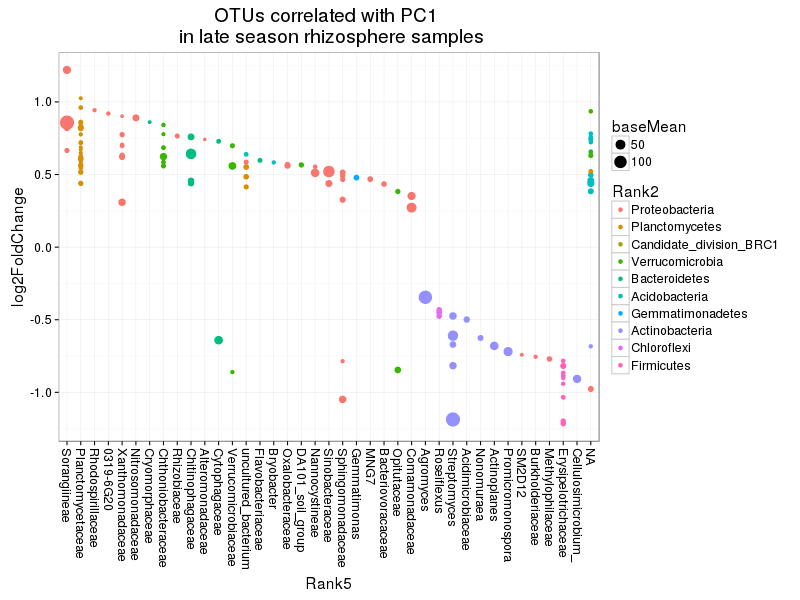

In [14]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with PC1 \n in late season rhizosphere samples")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [15]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC1")

131 OTUs vary significantly with PC1

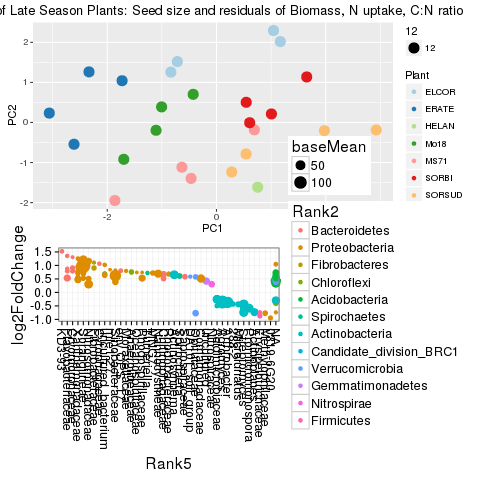

In [33]:
%%R
grid.arrange(p,p2, layout_matrix = rbind(c(1), c(2,2)))

## Late season Annuals - Deseq of Time /DAP

In [17]:
%%R
dds = phyloseq_to_deseq2(LS, ~Library + PC1 + DAP)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(LS)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

[1] "Intercept" "Library"   "PC1"       "DAP"      


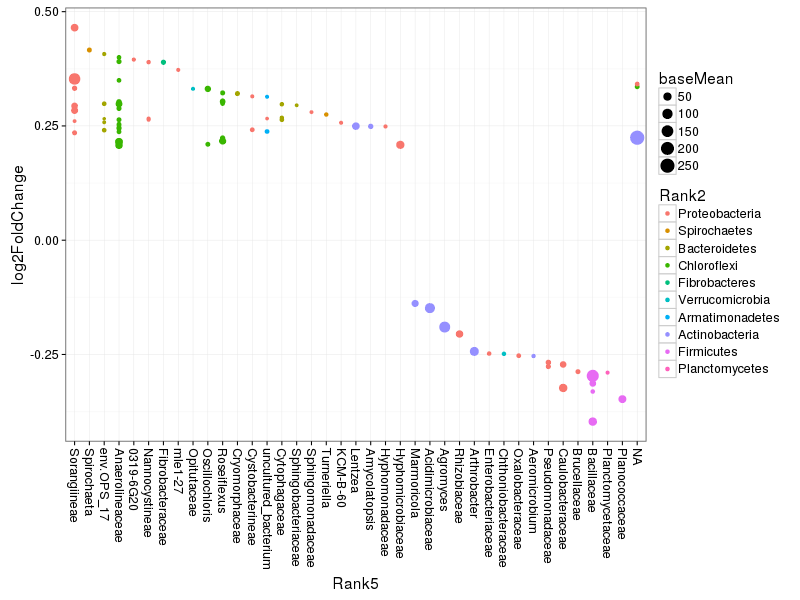

In [18]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [19]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with DAP")

90 OTUs vary significantly with DAP

## All Plants - CAP of functional traits

In [43]:
%%R
phy.neg = subset_samples(physeq.Full, Plant != "BARE"  & Treatment == "Nneg")
#sample_data(phy)$TimeClass = cut(sample_data(phy)$DAP, breaks = c(35,38, 62, 89), labels = c("A", "B", "C"))
#sample_data(phy)[,c("DAP", "TimeClass")]

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 
Importance of components:
                         PC1    PC2    PC3     PC4
Standard deviation     1.527 1.0247 0.7848 0.04564
Proportion of Variance 0.583 0.2625 0.1540 0.00052
Cumulative Proportion  0.583 0.8455 0.9995 1.00000
                        PC1        PC2        PC3          PC4
log(SeedSize_mg)  0.4375562 -0.3576541 -0.8249996 -0.001934066
A_Resid_logB      0.5769273 -0.3138561  0.4406140  0.611971036
A_Resid_logN      0.6312646  0.1535568  0.2699008 -0.710689000
A_Resid_logCN    -0.2778570 -0.8660244  0.2288852 -0.346999792


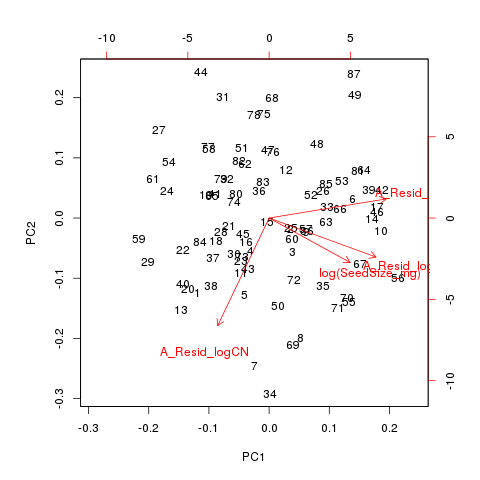

In [46]:
%%R
# PCA of all plants

# Add seed size information
Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
                    
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)


SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric


sd = as(sample_data(phy.neg), "data.frame")

sd = left_join(sd, SS, by = "Plant")

sd$Plant %>% levels %>% print


fit = prcomp(~log(SeedSize_mg) + A_Resid_logB + A_Resid_logN + A_Resid_logCN, data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)





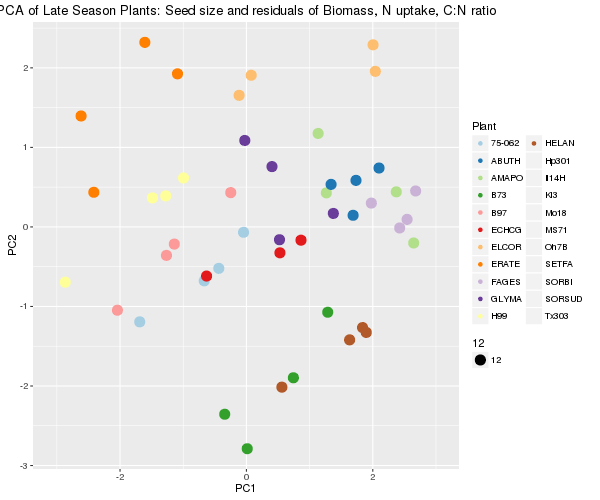

In [47]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
TM_Fit = cbind(sd, S)
rownames(TM_Fit) = TM_Fit$X.sample
sample_data(phy.neg) = TM_Fit



p = ggplot(TM_Fit, aes(PC1, PC2, colour = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Late Season Plants: Seed size and residuals of Biomass, N uptake, C:N ratio")
p

In [48]:
%%R
# Calculate w-unifrac distances
registerDoParallel(cores=28)
wunif.dist = phyloseq::distance(phy.neg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


[1] 72 61 36 79 53 57 88 84
Levels: 36 53 57 61 72 79 84 88
Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ PC1 + PC2 + PC3 + Condition(Library), data = data)
         Df SumOfSqs     F Pr(>F)    
Model     3  0.27814 3.679  0.001 ***
Residual 82  2.06644                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


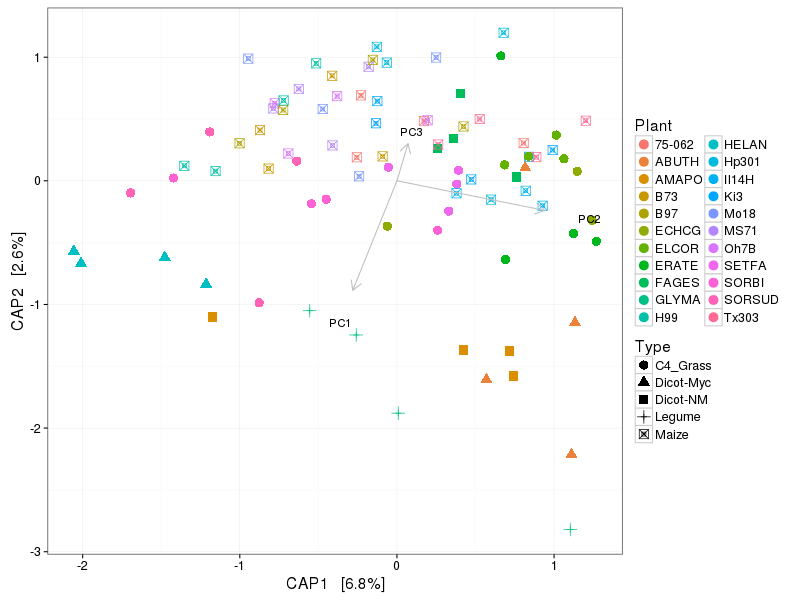

In [50]:
%%R -w 800 -h 600

dist = wunif.dist

sample_data(phy.neg)$DAP = as.factor(sample_data(phy.neg)$DAP)
unique(sample_data(phy.neg)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = phy.neg, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + PC3 + Condition(Library)
        )

        # CAP plot
        cap.plot <- plot_ordination(
            phy.neg, 
            cap.ord, 
            color = "Plant", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(colour = Plant), 
                alpha= 1, 
                size = 4) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p1 = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p1


## All plants - Deseq of Time 

In [ ]:
%%R

dds = phyloseq_to_deseq2(phy.neg, ~Library +  poly(DAP,2))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

In [ ]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
    #ggtitle("2nd order polynomial") +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [ ]:
%%R

DF.C = results(d_dds, name = "poly.DAP..2.1")

supp = tax_table(physeq.Full)
            if (!setequal(row.names(supp), row.names(DF.C))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF.C), row.names(supp)))
        }  

        DF.C = data.frame(DF.C, supp)
        DF.C$OTU = rownames(DF.C)

In [ ]:
%%R -w 800 -h 600
sigtabC = DF.C %>% filter(padj < 0.05)
x = tapply(sigtabC$log2FoldChange, sigtabC$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtabC$Rank2 = factor(as.character(sigtabC$Rank2), levels=names(x))
x = tapply(sigtabC$log2FoldChange, sigtabC$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtabC$Rank5 = factor(as.character(sigtabC$Rank5), levels=names(x))
    
ggplot(sigtabC, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
    ggtitle("1st order polynomial")+
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x


In [ ]:
%%R
head(DF)
colnames(DF) = paste(colnames(DF),".2", sep ="")
colnames(DF.C) = paste(colnames(DF.C),".1", sep ="")

In [ ]:
%%R
L2F.DAP = full_join(DF.C, DF[,c(1:6, 15)], by = c("OTU.1" = "OTU.2"))
dim(L2F.DAP) %>% print
head(L2F.DAP)


In [ ]:
%%R
sigtab = filter(L2F.DAP, padj.1 < 0.05 | padj.2 < 0.05)
cat(dim(sigtab)[1], "OTUs vary significantly with DAP")

In [ ]:
%%R
head(sigtab)

In [ ]:
%%R
#all significant OTUs
AllSig = sigtab$OTU.1

#OTUs with significant 1st order polynomial positive log 2 fold
sigtab.1 = filter(sigtab, log2FoldChange.1 > 0) %>% arrange(padj.1)
dim(sigtab.1) %>% print
rownames(sigtab.1) = sigtab.1$OTU.1 
Top10.1 = sigtab.1[1:10, "OTU.1"] #%>% row.names
Top10.1 %>% print

sigtab.1neg = filter(sigtab, log2FoldChange.1 < 0) %>% arrange(padj.1)
dim(sigtab.1neg) %>% print
rownames(sigtab.1neg) = sigtab.1neg$OTU.1 
Top10.1neg = sigtab.1neg[1:10, "OTU.1"] #%>% row.names
Top10.1neg %>% print

sigtab.2 = filter(sigtab, padj.2 < 0.05) %>% arrange(padj.2)
dim(sigtab.2) %>% print
rownames(sigtab.2) = sigtab.2$OTU.2 
Top10.2 = sigtab.2[, "OTU.1"] #%>% row.names
Top10.2 %>% print


# sigtab.2neg = filter(sigtab, log2FoldChange.2 < 0) %>% arrange(padj.2)
# dim(sigtab.2neg) %>% print
# rownames(sigtab.2neg) = sigtab.2neg$OTU.2 
# Top10.2neg = sigtab.2neg[1:10, "OTU.1"] #%>% row.names
# Top10.2neg %>% print

# physub = prune_taxa(Top20, phy) %>%  merge_samples("DAP")
# physub


In [ ]:
%%R
# create new deseq object with DAP as factor
phy = subset_samples(physeq.Full, Plant != "BARE")
phy = prune_taxa(AllSig, phy) %>% filter_taxa(function(x) max(x) > 100, TRUE)
phy

In [ ]:
%%R
# phy
sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
dds = phyloseq_to_deseq2(phy, ~Library + DAP)
d_dds = DESeq(dds, parallel = TRUE)

In [ ]:
%%R
tax_table(phy) %>% row.names

In [ ]:
%%R -w 800 -h 1200
p <- list()
Tinfo = as(tax_table(phy), "matrix")
ToGraph = tax_table(phy) %>% row.names
for (i in ToGraph){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
    
    
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i, "\n", Tinfo[i, 2], ": ", Tinfo[i, 6], sep = ""))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,c(p, ncol = 4))
#

In [ ]:
%%R -w 800 -h 1000
p <- list()
for (i in Top10.1neg){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i, "\n", Tinfo[i, 2], "\n", Tinfo[i, 6], sep = ""))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,p)
#

In [ ]:
%%R -w 800 -h 1200
p <- list()
for (i in Top10.2){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i, "\n", Tinfo[i, 2], "\n", Tinfo[i, 6], sep = ""))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,p)
#

In [ ]:
%%R
p <- list()
for (i in Top10.2neg){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,p)
#

In [ ]:
%%R
for (i in Top10.2){
p =  plotCounts(dds, gene=i, intgroup=c("DAP", "Plant"))  

}

In [ ]:
%%R -w 800 -h 400
library("scales")
d = plotCounts(dds, gene= "OTU.3", intgroup=c("DAP", "Plant"), returnData=TRUE)  
d = arrange(d, "DAP")
p = ggplot(d, aes(x = Plant, y = count)) + 
geom_point() +
scale_y_continuous(trans=log2_trans())

d = NULL
p 

In [ ]:
%%R
physeq.Full %>% tax_table %>% .[c("OTU.197", "OTU.101", "OTU.5", "OTU.271", "OTU.45", "OTU.10249", "OTU.3"), ]

In [ ]:
%%R
p = plot_bar(physub, "DAP", fill="Rank6")
p = p + facet_wrap(~OTU, ncol = 4, scales = "free_y")
p

In [ ]:
%%R
T = prune_taxa("OTU.1668", phy) %>% merge_samples("Plant")
p = plot_bar(T)
#p = p + facet_wrap(~OTU, ncol = 4, scales = "free_y")
p

## Panicoideae - Deseq of Time 

In [38]:
%%R
phy = subset_samples(physeq.Full, Plant %in% c("ECHCG", "SETFA", "MS71", "Mo18", "SORBI", "SORSUD", "ERATE", "ELCOR") & Treatment == "Nneg")
#sample_data(phy)$TimeClass = cut(sample_data(phy)$DAP, breaks = c(35,38, 62, 89), labels = c("A", "B", "C"))
#sample_data(phy)[,c("DAP", "TimeClass")]

In [39]:
%%R

dds = phyloseq_to_deseq2(phy, ~Library +  DAP)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 68 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: fitting model and testing

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept" "Library"   "DAP"      


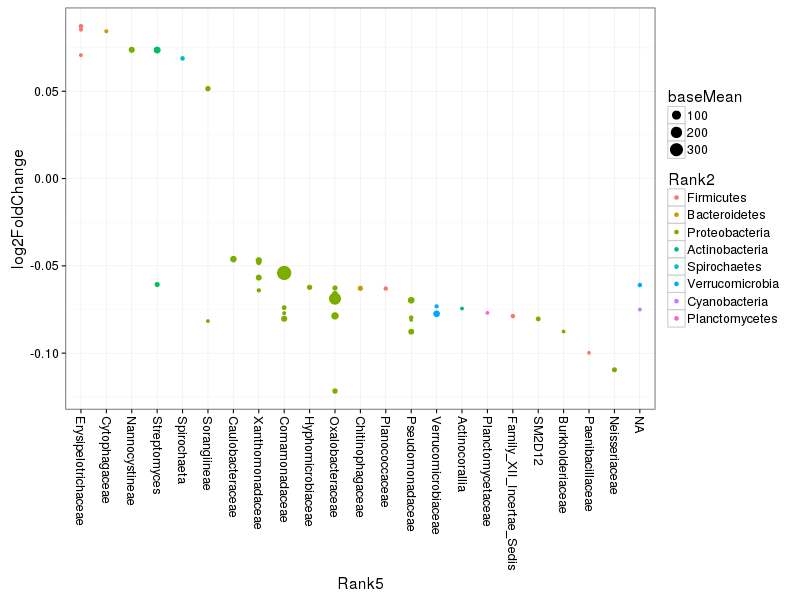

In [40]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
    #ggtitle("2nd order polynomial") +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [ ]:
%%R

# DF.1 = results(d_dds, name = "poly.DAP..2.1")

# supp = tax_table(physeq.Full)
#             if (!setequal(row.names(supp), row.names(DF.1))) {
#             stop("Ordination and supplementary data indices differ on the following:\n.",
#             setdiff(row.names(DF.1), row.names(supp)))
#         }  

#         DF.1 = data.frame(DF.1, supp)
#         DF.1$OTU = rownames(DF.1)

In [ ]:
%%R -w 800 -h 600
# sigtab1 = DF.1 %>% filter(padj < 0.05)
# x = tapply(sigtab1$log2FoldChange, sigtab1$Rank2, function(x) max(x))
# x = sort(x, TRUE)
# sigtab1$Rank2 = factor(as.character(sigtab1$Rank2), levels=names(x))
# x = tapply(sigtab1$log2FoldChange, sigtab1$Rank5, function(x) max(x))
# x = sort(x, TRUE)
# sigtab1$Rank5 = factor(as.character(sigtab1$Rank5), levels=names(x))
    
# ggplot(sigtab1, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
#     geom_point() +
#     theme_bw(base_size = 16) +
#     ggtitle("1st order polynomial")+
#   theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
# #x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
# #x = sort(x, TRUE)
# #x


In [ ]:
%%R
head(DF)
colnames(DF) = paste(colnames(DF),".2", sep ="")
colnames(DF.1) = paste(colnames(DF.1),".1", sep ="")

In [ ]:
%%R
head(DF)

In [ ]:
%%R
# L2F.DAP = full_join(DF.1, DF[,c(1:6, 15)], by = c("OTU.1" = "OTU.2"))
# head(L2F.DAP)

In [ ]:
%%R
# sigtab = filter(L2F.DAP, padj.1 < 0.05 | padj.2 < 0.05)
cat(dim(sigtab)[1], "OTUs vary significantly with DAP")

In [ ]:
%%R
sigtab = arrange(sigtab, padj)
dim(sigtab) %>% print
#rownames(sigtab) = sigtab$OTU.1 
Top10.1 = sigtab[,"OTU"] 
Top10.1

# sigtab = arrange(sigtab, padj.2)
# dim(sigtab) %>% print
# rownames(sigtab) = sigtab$OTU.1 
# Top10.2 = sigtab[1:10,] %>% row.names
# Top10.2
# physub = prune_taxa(Top20, phy) %>%  merge_samples("DAP")
# physub


In [ ]:
%%R
# create new deseq object with DAP as factor
#phy = subset_samples(physeq.Full, Plant != "BARE")
sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
dds = phyloseq_to_deseq2(phy, ~DAP)
d_dds = DESeq(dds, parallel = TRUE)

In [ ]:
%%R
for (i in Top10.1){
  plotCounts(dds, gene=i, intgroup=c("DAP", "Plant"))  

}

#

In [ ]:
%%R
for (i in Top10.2){
  plotCounts(dds, gene=i, intgroup=c("DAP", "Plant"))  

}

#

In [ ]:
%%R
colnames(DF)

In [ ]:
%%R
DF %>% filter(OTU.2 %in% c("OTU.4", "OTU.20"))

# Time without polynomial

In [53]:
%%R
phy.neg = subset_samples(phy, Plant != "BARE"  & Treatment == "Nneg" & Plant %in% c("ERATE", "HELAN", 
            "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18"))
#sample_data(phy)$TimeClass = cut(sample_data(phy)$DAP, breaks = c(35,38, 62, 89), labels = c("A", "B", "C"))
#sample_data(phy)[,c("DAP", "TimeClass")]
phy.neg

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 55 samples ]
sample_data() Sample Data:       [ 55 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]


In [54]:
%%R

dds = phyloseq_to_deseq2(phy.neg, ~DAP)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy.neg)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 31 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept" "DAP"      


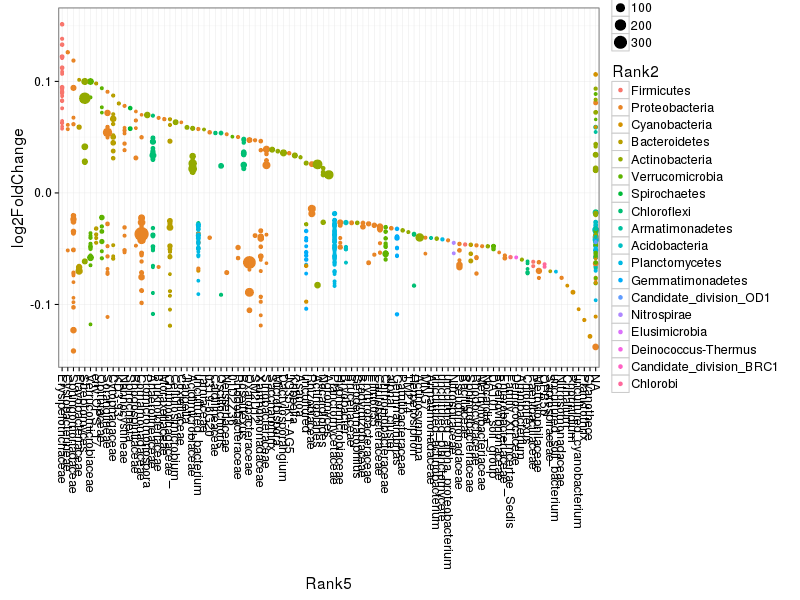

In [55]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
    #ggtitle("2nd order polynomial") +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [57]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with DAP")

586 OTUs vary significantly with DAP

In [58]:
%%R
sigtab.1 =  arrange(sigtab, padj)
rownames(sigtab.1) = sigtab.1$OTU 
Sig = sigtab.1[, "OTU"] #%>% row.names
#Top20 %>% print

In [59]:
%%R
phy.p = filter_taxa(phy.neg, function(x) max(x) > 100, TRUE)
phy.p = prune_taxa(Sig, phy.p) 
phy.p

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 92 taxa and 55 samples ]
sample_data() Sample Data:       [ 55 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 92 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 92 tips and 91 internal nodes ]


In [60]:
%%R
# phy
sample_data(phy.p)$DAP = as.factor(sample_data(phy.p)$DAP)
dds = phyloseq_to_deseq2(phy.p, ~DAP)
d_dds = DESeq(dds, parallel = TRUE)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [61]:
%%R
tax_table(phy.p) %>% row.names

 [1] "OTU.284"   "OTU.307"   "OTU.277"   "OTU.681"   "OTU.202"   "OTU.161"  
 [7] "OTU.610"   "OTU.12453" "OTU.630"   "OTU.265"   "OTU.488"   "OTU.100"  
[13] "OTU.102"   "OTU.397"   "OTU.8671"  "OTU.378"   "OTU.188"   "OTU.57"   
[19] "OTU.414"   "OTU.10692" "OTU.141"   "OTU.261"   "OTU.120"   "OTU.2076" 
[25] "OTU.160"   "OTU.621"   "OTU.244"   "OTU.53"    "OTU.33"    "OTU.216"  
[31] "OTU.43"    "OTU.148"   "OTU.808"   "OTU.92"    "OTU.173"   "OTU.7529" 
[37] "OTU.1403"  "OTU.162"   "OTU.10249" "OTU.4"     "OTU.7778"  "OTU.208"  
[43] "OTU.5574"  "OTU.134"   "OTU.1998"  "OTU.11012" "OTU.11302" "OTU.74"   
[49] "OTU.10442" "OTU.5436"  "OTU.9501"  "OTU.10"    "OTU.641"   "OTU.5214" 
[55] "OTU.4040"  "OTU.101"   "OTU.45"    "OTU.23"    "OTU.152"   "OTU.10253"
[61] "OTU.114"   "OTU.49"    "OTU.4378"  "OTU.199"   "OTU.29"    "OTU.107"  
[67] "OTU.10375" "OTU.8916"  "OTU.329"   "OTU.183"   "OTU.25"    "OTU.189"  
[73] "OTU.117"   "OTU.200"   "OTU.516"   "OTU.41"    "OTU.197"   "OTU.63"   

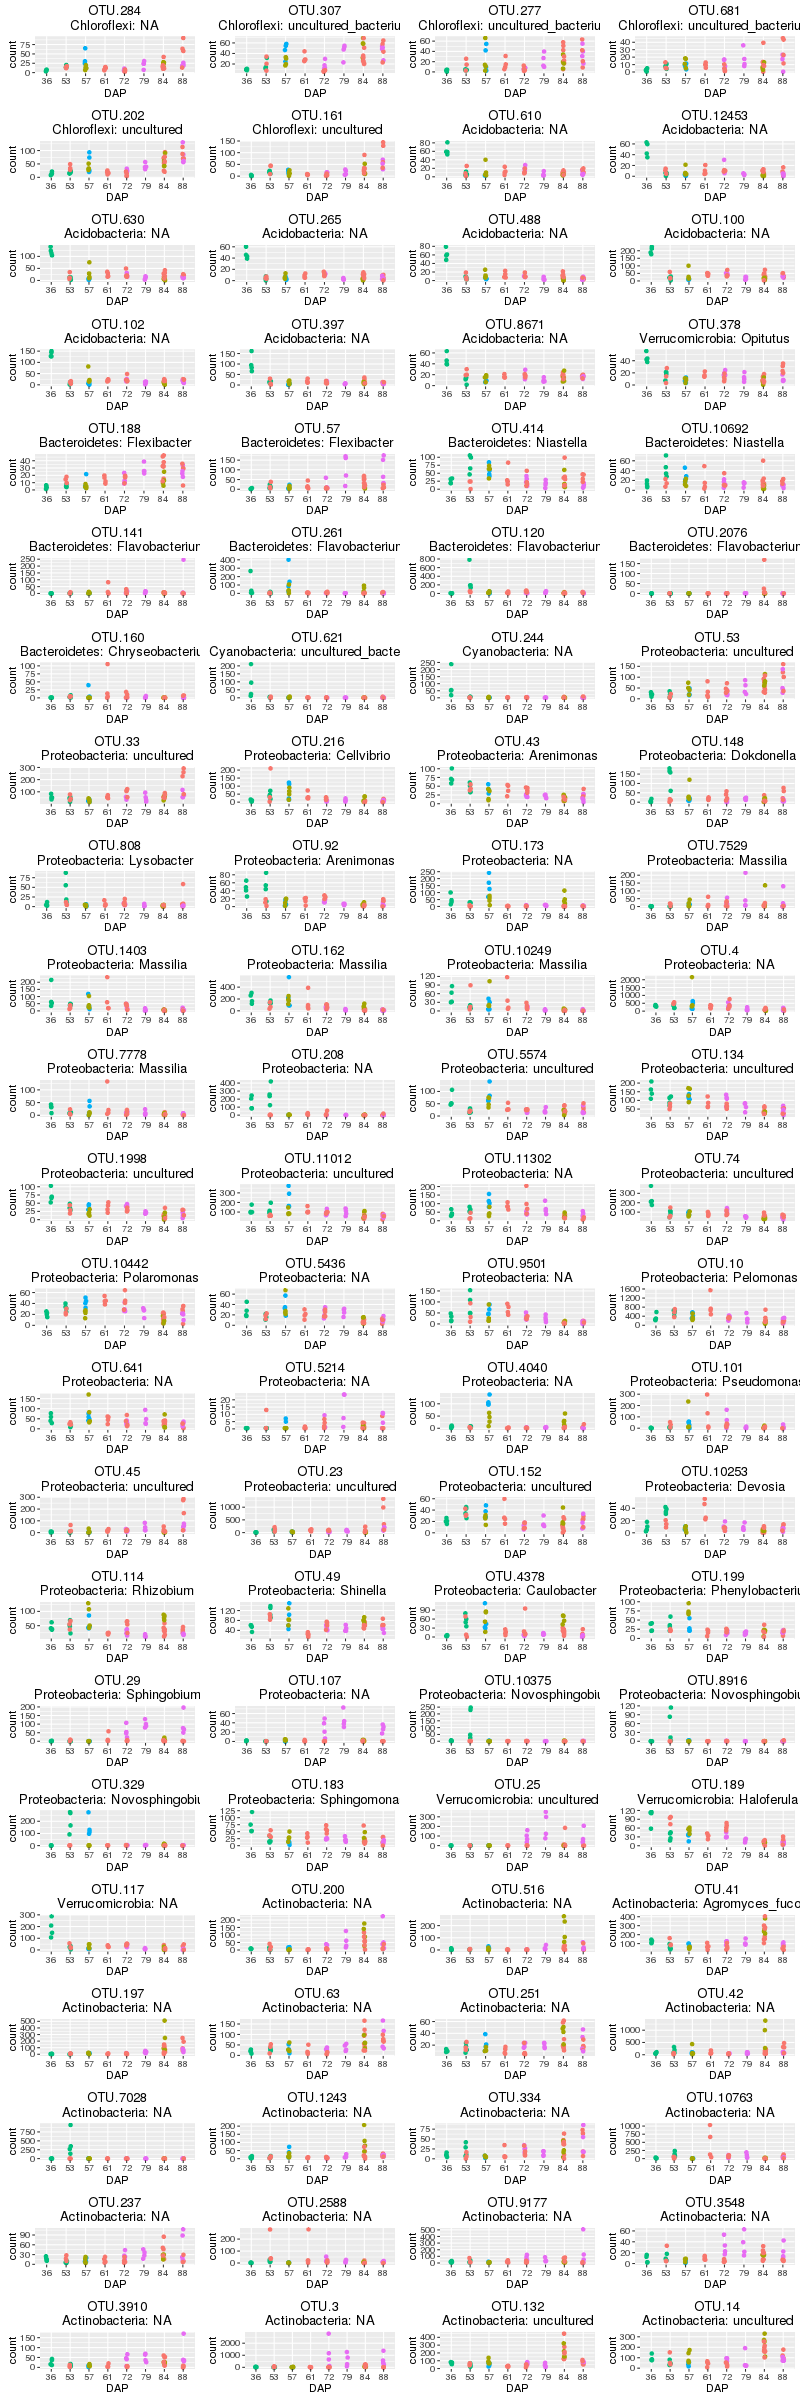

In [63]:
%%R -w 800 -h 2400
p <- list()
Tinfo = as(tax_table(phy.p), "matrix")
ToGraph = tax_table(phy.p) %>% row.names
for (i in ToGraph){
  d = plotCounts(dds, gene=i, intgroup=c("DAP", "Type"), returnData = TRUE)  
    
    
p[[i]] = ggplot(d, aes(x=DAP, y=count, color = Type)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
  theme(legend.position="none") +
    ggtitle(paste(i, "\n", Tinfo[i, 2], ": ", Tinfo[i, 6], sep = ""))
  }

#legend = get_legend(p[1])
do.call(grid.arrange,c(p, ncol = 4))
#


# Maize

## Maize - PCA of functional traits 

In [ ]:
%%R
# PCA of annuals
M_neg = subset_samples(physeq.Full, Type == "Maize" & Treatment == "Nneg" )
# subset for later deSEQ2 analysis
M_neg_NR = subset_samples(physeq.NR, Type == "Maize" & Treatment == "Nneg" )

sd = as(sample_data(M_neg), "data.frame")
sd$Plant %>% levels %>% print

fit = prcomp(~M_Resid_logB + M_Resid_logN + M_Resid_logCN + d15N, data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)




In [ ]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
M_Fit = cbind(sd, S)
sample_data(M_neg) = M_Fit
sample_data(M_neg_NR) = M_Fit

p = ggplot(M_Fit, aes(PC1, PC2, colour = Plant, 
                       size = 12), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Maize: Biomass, N uptake, C:N ratio, 15N")
p

Notes:
* PC1 positively correlated with plant size and N uptake
* PC2 negatively correlated with plant C:N
* genotype effect is most captured on PC2

## Maize - CAP analysis with Principle components

In [ ]:
%%R
# Calculate w-unifrac distances
registerDoParallel(cores=28)
M_neg.wunif.dist = phyloseq::distance(M_neg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

M_neg.unif.dist = phyloseq::distance(M_neg, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)



In [ ]:

%%R -w 800 -h 600
### Functional controls Maize, CAP
phy = M_neg
dist = M_neg.wunif.dist

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print

#Weighted unifrac CAP

        # CAP ordinate
        cap.ord = ordinate(
            physeq = phy, 
            method = "CAP",
            distance = dist,
            formula = ~ PC1 + PC2 + Condition(Library)
        )

        # CAP plot
        cap.plot <- plot_ordination(
            phy, 
            cap.ord, 
            color = "Plant", 
            axes = c(1,2)
            ) + 
            aes(shape = Type) + 
            geom_point(aes(colour = Plant), 
                alpha= 1, 
                size = 4) + 
            #geom_point(colour = "grey90", 
            #    size = 1.5) + 
            theme_bw(base_size = 16)
            #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
            #    "#1919ff", "darkorchid3", "magenta"))


        # Now add the environmental variables as arrows
        arrowmat <- vegan::scores(cap.ord, display = "bp")


        # Add labels, make a data.frame
        arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

        # Define the arrow aesthetic mapping
        arrow_map <- aes(xend = CAP1, 
            yend = CAP2, 
            x = 0, 
            y = 0, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        label_map <- aes(x = 1.3 * CAP1, 
            y = 1.3 * CAP2, 
            shape = NULL, 
            color = NULL, 
            label = labels)

        arrowhead = arrow(length = unit(0.02, "npc"))

        # Make a new graphic
        p = cap.plot + 
            geom_segment(arrow_map, 
                size = .5, 
                data = arrowdf, 
                color = "gray", 
                arrow = arrowhead
                ) + 
            geom_text(label_map, 
                size = 4,  
                data = arrowdf, 
                show_guide = FALSE)

anova(cap.ord) %>% print
p


CAP model is not significant

## Maize - Deseq of PC2

In [ ]:
%%R
dds = phyloseq_to_deseq2(M_neg_NR, ~Library + PC2)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg)
            if (!setequal(row.names(res), row.names(res))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

In [ ]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.1)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [ ]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC2")

## Maize - Deseq of PC1

In [ ]:
%%R
dds = phyloseq_to_deseq2(M_neg_NR, ~Library + PC1)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(A_neg)
            if (!setequal(row.names(res), row.names(res))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

In [ ]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.1)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [ ]:
%%R
cat(dim(sigtab)[1], "OTUs vary significantly with PC1")